In [45]:
import numpy as np
import matplotlib.pyplot as plt
import writhe_tools
from writhe_tools import utils
from writhe_tools.utils import (load_dict,
                                load_dict,
                                lsdir,
                                num_str,
                                load_array_dir,
                                symbols,
                                group_by, indices_stat,
                                make_index_function,
                                reindex_list
                               )

from writhe_tools.plots import fes2d, subplots_fes2d, proj2d, subplots_proj2d, annotated_matrix_plot, lineplot1D, get_color_list
from writhe_tools.stats import rotate_points
from writhe_tools import plots
from cycler import cycler
from writhe_tools.utils import save_dict
from writhe_tools.msm_tools import (MarkovModel,
                                    reindex_dtraj,
                                    reindex_matrix,
                                   )
from writhe_tools.writhe import Writhe
from writhe_tools.stats import Kmeans
#import pyemma
import deeptime
from copy import deepcopy
from functools import partial
from scipy.stats import bootstrap

def longest_timescale(dtraj, lagtime, bayes:bool=False, reversible:bool=False):
    # deal with failing models during parameter scans
    if bayes:
        try:
            stats = deeptime.markov.msm.BayesianMSM(lagtime=lagtime,
                                                    reversible=reversible,
                                                    n_samples=1000).fit_fetch(dtraj).gather_stats('timescales',
                                                                                                 confidence=0.95)
            return stats.mean[0], stats.L[0], stats.R[0]
        except:
            return np.nan
    else:   
        try:
            return deeptime.markov.msm.MaximumLikelihoodMSM(reversible=reversible).fit_fetch(dtraj,
                                                                                       lagtime=lagtime).timescales(1).item()
        except:
            return np.nan

def iter_longest_timescale(dtraj, lagtimes = np.arange(5, 550, 50), bayes=False, reversible:bool=False):
    return np.array([longest_timescale(dtraj, lag, bayes=bayes, reversible=reversible) for lag in lagtimes])

# split individual trajectories from concatenated ab42 trajectories
split = np.cumsum(np.load(*lsdir("/data/writhe/ab42", keyword="lengths")))[:-1]


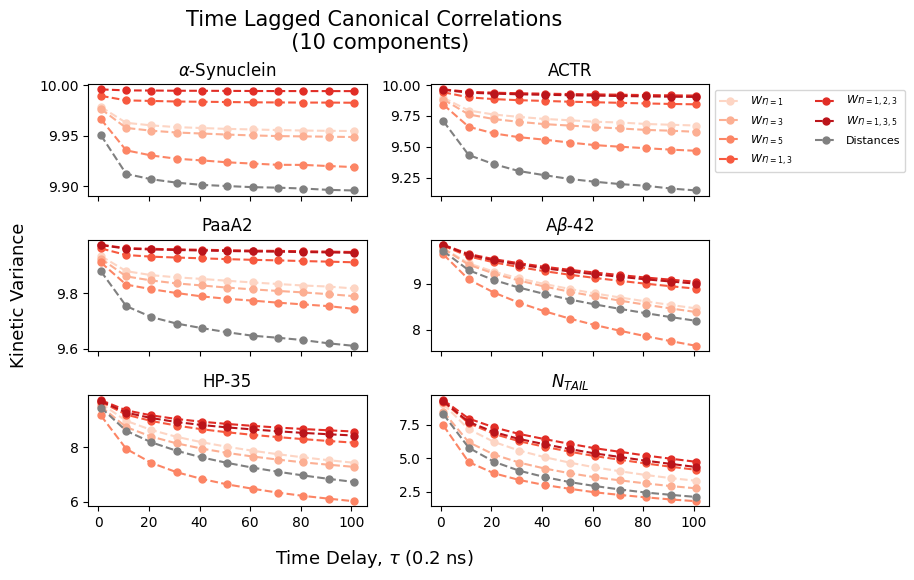

In [28]:
# paths=["/home/t/writhe/asyn/full/apo/data/tcca/",
#        "/home/t/writhe/actr/data/tcca/",
#        "/data/writhe/paaa2/tcca/",
#        "/data/writhe/ab42/tcca/",
#        "/home/t/writhe/hp35/data/tcca/",
#        "/home/t/writhe/ntail/data/tcca/",
#        ]
root = "/data/writhe_paper_data"
proteins = ["asyn", "actr", "paaa2", "ab42", "hp35", "ntail"]
names = [r"$\alpha$-Synuclein", "ACTR", "PaaA2", r"A$\beta$-42", "HP-35", r"$N_{TAIL}$"]
paths = [f"{root}/{i}" for i in proteins]
atoms = [140, 71, 71 , 35, 21]

tcca_scores = {i : dict(path=j+"/tcca") for i,j in zip(proteins, paths)}

keyword = ["val", "npy"]           
formatter = lambda k : k if int(k) <= 10 else ",".join(str(k))
file_to_key = lambda k : formatter(utils.num_str(utils.rm_path(k), return_str=False))
load = lambda x : np.load(x)[:10] # compute vamp score with dimension 10

for key, value in tcca_scores.items():
            
    #writhe
    value.update({file_to_key(dir): load_array_dir(dir, keyword=keyword, stack=True, load=load )
                 for dir in lsdir(value["path"]+"/writhe", keyword="length", exclude=".")})
    #distances
    value.update(dict(distances=load_array_dir(value["path"]+"/distances", keyword=keyword, stack = True)))



fig, axes = plt.subplots(3,2,figsize=(7,5),sharey=False, sharex=True)
for ax, name,  (key, value) in zip(axes.flat, names, tcca_scores.items()):
    
    ax.set_prop_cycle((cycler(color=writhe_tools.plots.get_color_list(6,
                                                                     "Reds",
                                                                      trunc=50,
                                                                      pre_trunc=40))))
    ax.set_title(name)
    
    if name == r"$\alpha$-Synuclein":
        ax.yaxis.set_major_formatter('{x:.2f}')

    for k, v in value.items():
        
        #if k not in [1, 3, 5, "1,3", "1,3,5", "distances"]: continue # pickout the data we want to look at
        
        if k in [1, 3, 5, "1,3", "1,3,5", "1,2,3"]:
            
            if len(v) != 11: #account for the fact that some datasets include scores for tau=5 steps
                v = np.delete(v, 1, axis=0)

            ax.plot(np.arange(1, 111, 10).astype(int),
                    (v[:,:10]**2).sum(-1),
                    label=f"$Wr$$_{{l={k}}}$",
                    lw=1.5,
                    ls="--",
                    marker="o",
                    ms=5,
                   )
                #ax.legend(bbox_to_anchor=[1,1], fontsize=8)
        
        elif k == "distances":
            
            if len(v) != 11: #account for the fact that some datasets include scores for tau=5 steps
                v = np.delete(v, 1, axis=0)
                
            ax.plot(np.arange(1, 111, 10).astype(int),
                    (v[:,:10]**2).sum(-1),
                    label="Distances",
                    lw=1.5,
                    ls="--",
                    marker="o",
                    color="gray",
                    ms=5)
        
        else: continue
        #ax.set_xticks(np.linspace(1,111,11), labels=)

fig.tight_layout()

axes[0,-1].legend(bbox_to_anchor=[1,1],
                  fontsize=8,
                  ncol=2)

fig.supxlabel(r"Time Delay, $\tau$ (0.2 ns)",
              y=-0.05,
              fontsize=13)

fig.suptitle("Time Lagged Canonical Correlations\n  (10 components)",
             fontsize=15
             ,y=1.07)

fig.supylabel("Kinetic Variance",
              y=0.5,
              x=-0.02,
              fontsize=13)


plt.savefig("/home/t/writhe/tcca_comp_fig.png", dpi=1300, bbox_inches="tight")


In [ ]:
def acf(x):
    """
    Computes the autocorrelation function (ACF) of a 1D time series using FFT.

    Parameters:
    - x (np.ndarray): Input 1D signal.

    Returns:
    - acf (np.ndarray): The autocorrelation function.
    """
    N = len(x)
    x = x - np.mean(x)
    return np.fft.ifft(np.abs(np.fft.fft(x, n=2*N))**2).real[:N] / (N * np.var(x))

def get_time(acf, cutoff=np.exp(-1)):

    return np.sum(acf[:(acf <= cutoff).argmax() + 1])
    
import ray
@ray.remote
def get_acf_time(x, cutoff=np.exp(-1)):
    return get_time(acf(x), cutoff=np.exp(-1))

writhe_paths = [f"/data/writhe_paper_data/{i}/writhe" for i in ['asyn', 'actr','paaa2', 'ab42', 'hp35', 'ntail']]
def load_writhes(protein_index, length_indices:list=[0] ):
    return [Writhe.load(x).writhe_features for x in reindex_list(lsdir(writhe_paths[protein_index], keyword="dict"), length_indices)]

matrices = [[np.array(ray.get([get_acf_time.remote(i) for i in j.T])) for j in load_writhes(j)] for j in [0, 1, 2, 4, 5]]
save_dict("correlation_matrices_truncated_integral.pkl", matrices)

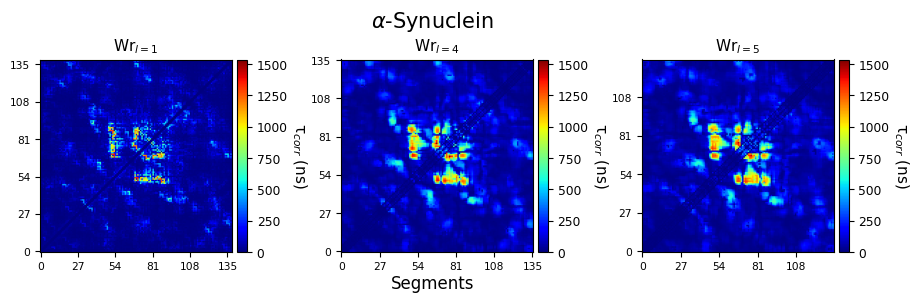

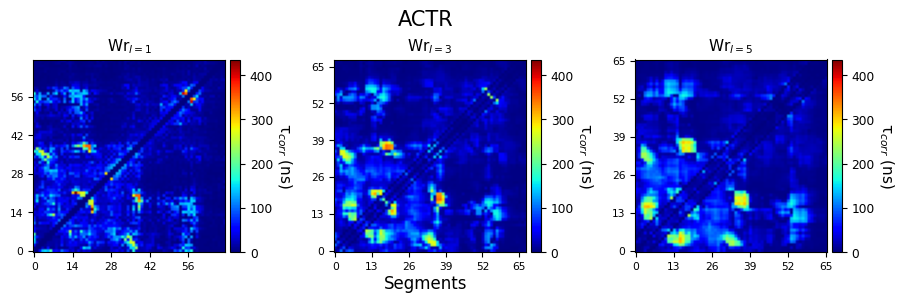

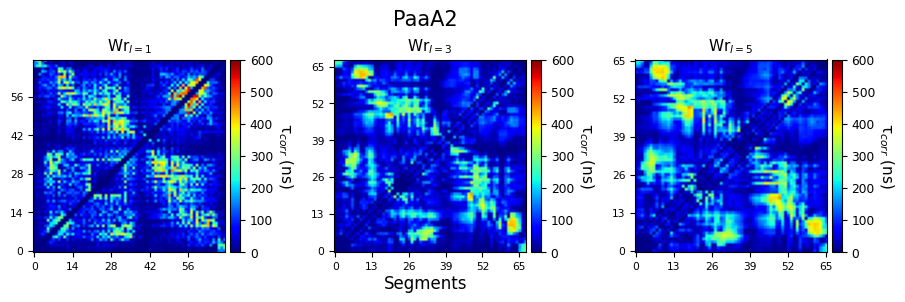

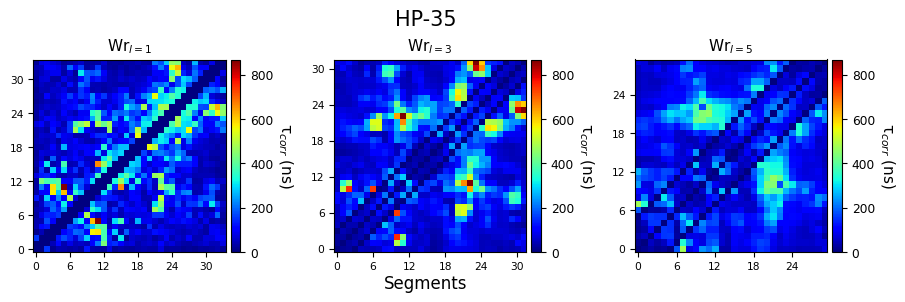

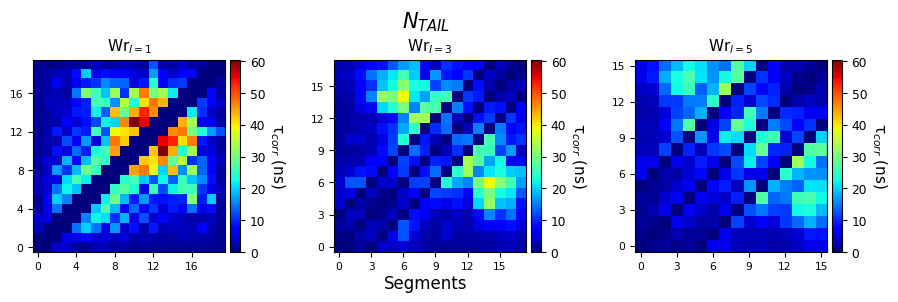

In [29]:
from writhe_tools.plots import plot_distance_matrix
from writhe_tools.writhe import to_writhe_matrix
acf_times_full = load_dict("correlation_matrices_full_integral.pkl")
atoms = [140, 71, 71 , 35, 21]
loop = zip([0, 1, 2, 4, 5], atoms, acf_times_full,
          [np.array(i) for i in [[0, 3, 4], [0, 2, 4], [0, 2, 4], [0, 2, 4], [0, 2, 4]]])
_i = 0
for j, n, matrix, idx in loop :
    #matrices = [np.array(ray.get([get_acf_time.remote(i) for i in j.T])) for j in load_writhes(j)]
    #all_matrices.append(matrices)
    fig, axes = plt.subplots(1, 3, figsize=(11, 2.5), sharey=False)
    
    
    for i, l, ax in zip(reindex_list(matrix, idx), idx+1, axes.flat):
        plot_distance_matrix(to_writhe_matrix(i, n, l ).squeeze() * 0.2,
                             cmap="jet",
                             ax=ax,
                             vmax=max(map(max, matrix))*0.2-(1500*0.2 if n == 35 else 0),
                             cbar_label=rf"{symbols('tau')}$_{{corr}}$ (ns)",
                             title=fr"$\text{{Wr}}_{{l={l}}}$",#Wr_{l=}length {l}",
                             font_scale=1.1,
                             aspect="equal",
                             xticks = np.arange(0, n - l),
                             yticks = np.arange(0, n - l),
                             label_stride=int((n-l)/5),
                             xticks_rotation=0,
                            )
        #ax.grid()
    fig.suptitle(f"{names[j]}", y=1.08, size=15, x=.52)
    #fig.supylabel("Segments")
    fig.supxlabel("Segments", y = -0.05, x=.52)

    plt.savefig("./"+str(_i)+".png", bbox_inches="tight")
    _i+=1

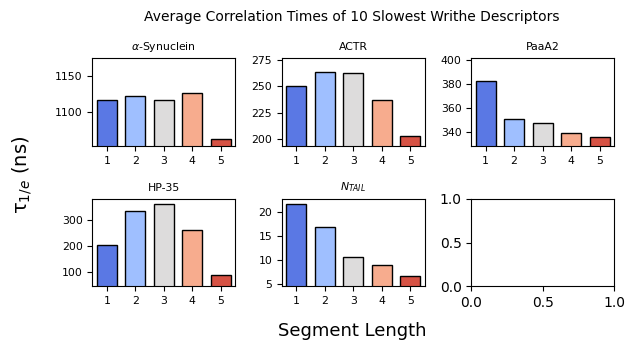

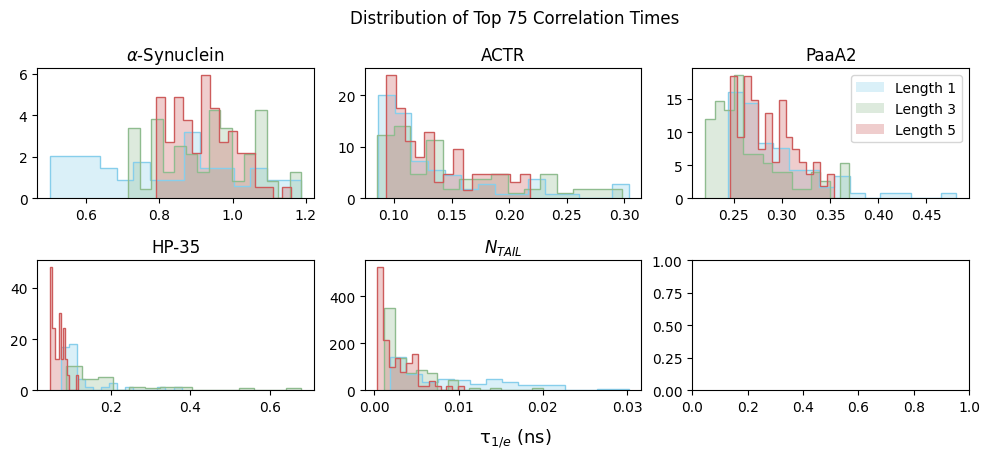

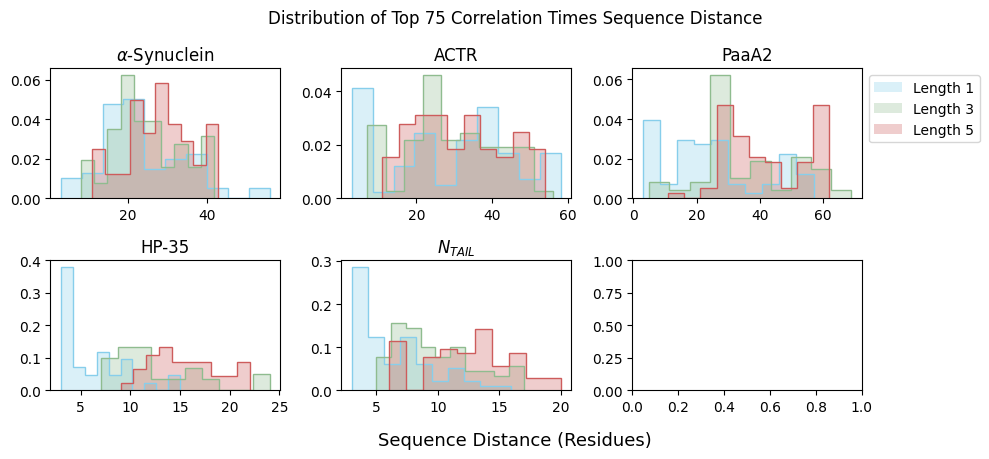

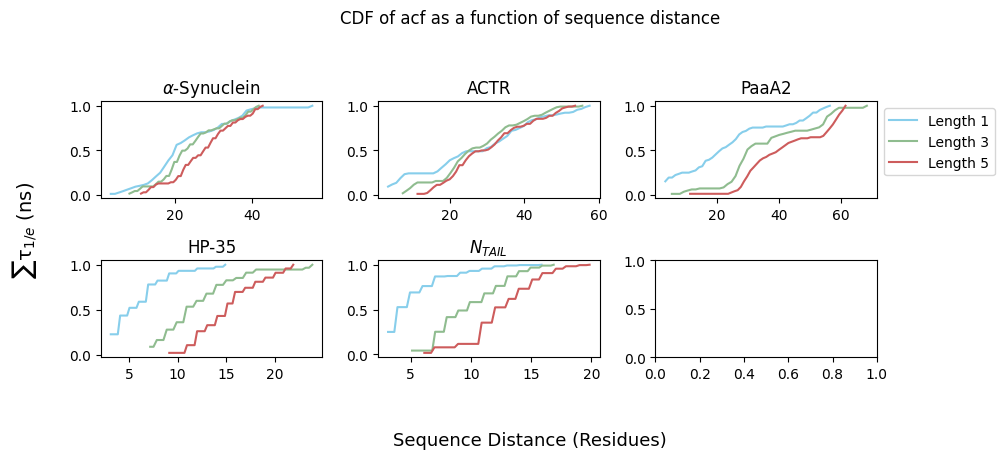

In [31]:
from writhe_tools.plots import box_plot
from writhe_tools.stats import pmf
from writhe_tools.utils import get_segments
fig, axes = plt.subplots(2, 3, figsize=(6, 3))
fig_, axes_ = plt.subplots(2, 3, figsize=(10, 4))
fig__, axes__ = plt.subplots(2, 3, figsize=(10, 4))
fig___, axes___ = plt.subplots(2, 3, figsize=(10, 4))

j=1
acf_times_trunc = load_dict("correlation_matrices_truncated_integral.pkl")
for ax, ax_, ax__, ax___, i, name, atom in zip(axes.flat, 
                                               axes_.flat,
                                               axes__.flat,
                                       
                                               axes___.flat,
                                               acf_times_trunc,
                                               reindex_list(names, [0, 1, 2, 4, 5]),
                                               atoms):
    
    #plt.plot(np.fromiter(map(np.max, i), float
    ns = 75 if name != 'HP-35' else 35
    rang = (max(np.fromiter(map(lambda x : np.max(np.sort(x)[-ns:]), i), float) * 0.2),
            min(np.fromiter(map(lambda x : np.min(np.sort(x)[-ns:]), i), float) * 0.2))
    
            
    #(np.array(i)[::2].min(), np.array(i)[::2].max())
    for a, c, l in zip(i[::2], [ 'skyblue', 'darkseagreen', 'indianred'], [1, 3, 5]):
        #stop = int(len(a) * .05)
        resort = np.argsort(a)[::-1]
        seg = get_segments(atom, l)[resort[:ns]]
        dist = abs(seg[:, 0] - seg[:, -1])
        # seg = s[:ns]
        # dist = d[:ns]
        ax_.hist(a[resort[:ns]] * 0.2e-3,
                 15,
                 alpha=.3,
                 color=c,
                 density=True,
                 label=f"Length {l}",)
        ax_.hist(a[resort[:ns]] * 0.2e-3,
                 15,
                 histtype='step',
                 color=c,
                 density=True,
                )
        
        ax__.hist(dist,
                 10,
                 histtype='step',
                 color=c,
                 density=True,
                )
        ax__.hist(dist,
                 10,
                 alpha=.3,
                 color=c,
                 density=True,
                 label=f"Length {l}",)

        
        p, centers = reindex_list(pmf(dist, bins=50, weights=a[resort[:ns]]), [0, -1])
        ax___.plot(centers,
                   np.cumsum(p),
                   color=c,
                  label=f"Length {l}")

        if j == 3:
            ax_.legend(bbox_to_anchor=[1, 1])
            ax__.legend(bbox_to_anchor=[1, 1])
            ax___.legend(bbox_to_anchor=[1, 1])
    
    ax_.set_title(name)
    ax__.set_title(name)
    ax___.set_title(name)

    ts = np.fromiter(map(lambda x : np.mean(np.sort(x)[-10:]), i), float) * 0.2
    box_plot(ts,
             ax=ax,
             width=.7,
             cmap="coolwarm",
             ymin=ts.min() - \
             (ts.max() - ts.min())*.15,
             ymax = 1175 if j ==1 else None,
             color_height=False,
             font_scale=1.3,
             title=name)
    j+=1
#fig.legend(ncol=2)
fig.tight_layout()
fig_.tight_layout()
fig__.tight_layout()
fig___.tight_layout()

fig.supylabel(rf"{symbols('tau')}$_{{1/e}}$ (ns)", x=-0.05, size=14)
fig.suptitle("Average Correlation Times of 10 Slowest Writhe Descriptors", x=.52, y = 1+0.05, size=10)
fig.supxlabel(r"Segment Length", x=.52, y = -0.05, size=13)
fig_.suptitle("Distribution of Top 75 Correlation Times",
              x=.52,
              y = 1+0.05,
              size=12)

fig_.supxlabel(rf"{symbols('tau')}$_{{1/e}}$ (ns)",
               x=.52,y = -0.05, size=13)


fig__.suptitle("Distribution of Top 75 Correlation Times Sequence Distance",
              x=.52,
              y = 1+0.05,
              size=12)
fig__.supxlabel("Sequence Distance (Residues)",
               x=.52,y = -0.05, size=13)

fig___.supylabel(r'$\sum$'+rf"{symbols('tau')}$_{{1/e}}$ (ns)", x=0, size=14)

fig___.supxlabel("Sequence Distance (Residues)",
               x=.52,y = -0.05, size=13)
fig___.suptitle("CDF of acf as a function of sequence distance",
                x=.52,
                 y = 1+0.05,
              size=12)
fig___.tight_layout()


#fig.savefig("./length_autocorrelations", dpi=1200, bbox_inches="tight")

In [32]:
from writhe_tools.utils import get_segments
import pandas
from IPython.display import display

slowest = [list(map(np.argmax, i)) for i in acf_times_full]

slowest_segments = pandas.DataFrame(dict(zip(reindex_list(names, [0, 1, 2, 4, 5,]),
                   [{i : get_segments(n, i)[k]
                   for i, k in zip([1,2,3,4,5], reindex_list(slowest[l], [0,1,2,3,4]))}
                   for l, n in enumerate(atoms)])))

#slowest_segments.index = [1, 2, 3, 4, 5]
slowest_segments = slowest_segments.reset_index()
slowest_segments.rename(columns={'index':'Length'}, inplace=True)
slowest_segments.index=5 * [""]
print("           Segment pairs (start and end atoms) with slowest writhe")
display(slowest_segments[::2])
#slowest_segments.index.name = "Length"
#from tabulate import tabulate
#print(tabulate(slowest_segments, headers='keys', tablefmt='pretty', showindex='always'))

           Segment pairs (start and end atoms) with slowest writhe


Length $\alpha$-Synuclein              ACTR             PaaA2  \
       1   [51, 52, 70, 71]  [15, 16, 21, 22]  [53, 54, 56, 57]   
       3   [68, 71, 81, 84]  [18, 21, 36, 39]  [20, 23, 48, 51]   
       5   [67, 72, 76, 81]    [4, 9, 15, 20]  [18, 23, 49, 54]   

             HP-35        $N_{TAIL}$  
    [5, 6, 11, 12]  [10, 11, 13, 14]  
  [23, 26, 31, 34]    [6, 9, 14, 17]  
     [0, 5, 7, 12]   [7, 12, 13, 18]

In [36]:
# select projections - 1, 3, (1, 3), 
tcca_projections = {key:{} for key in tcca_scores.keys()}
lengths = [123, 135, 123, 135, 123, 123]
lags = [21, 31, 31, 11, 31, 11]

for length, lag, value, path in zip(lengths, lags, tcca_projections.values(), paths):
    print(path)
    
    kws = [f"lag_{lag}", "proj"]
    
    value["writhe"] = [load_array_dir(lsdir(f"{path}/tcca/writhe", keyword=f"_{l}")[0], kws, stack=True).squeeze() for l 
                      in [1, 3, 13, length]]
    
    value["distances"] = load_array_dir(f"{path}/tcca/distances", kws, stack=True).squeeze()

/data/writhe_paper_data/asyn
/data/writhe_paper_data/actr
/data/writhe_paper_data/paaa2
/data/writhe_paper_data/ab42
/data/writhe_paper_data/hp35
/data/writhe_paper_data/ntail


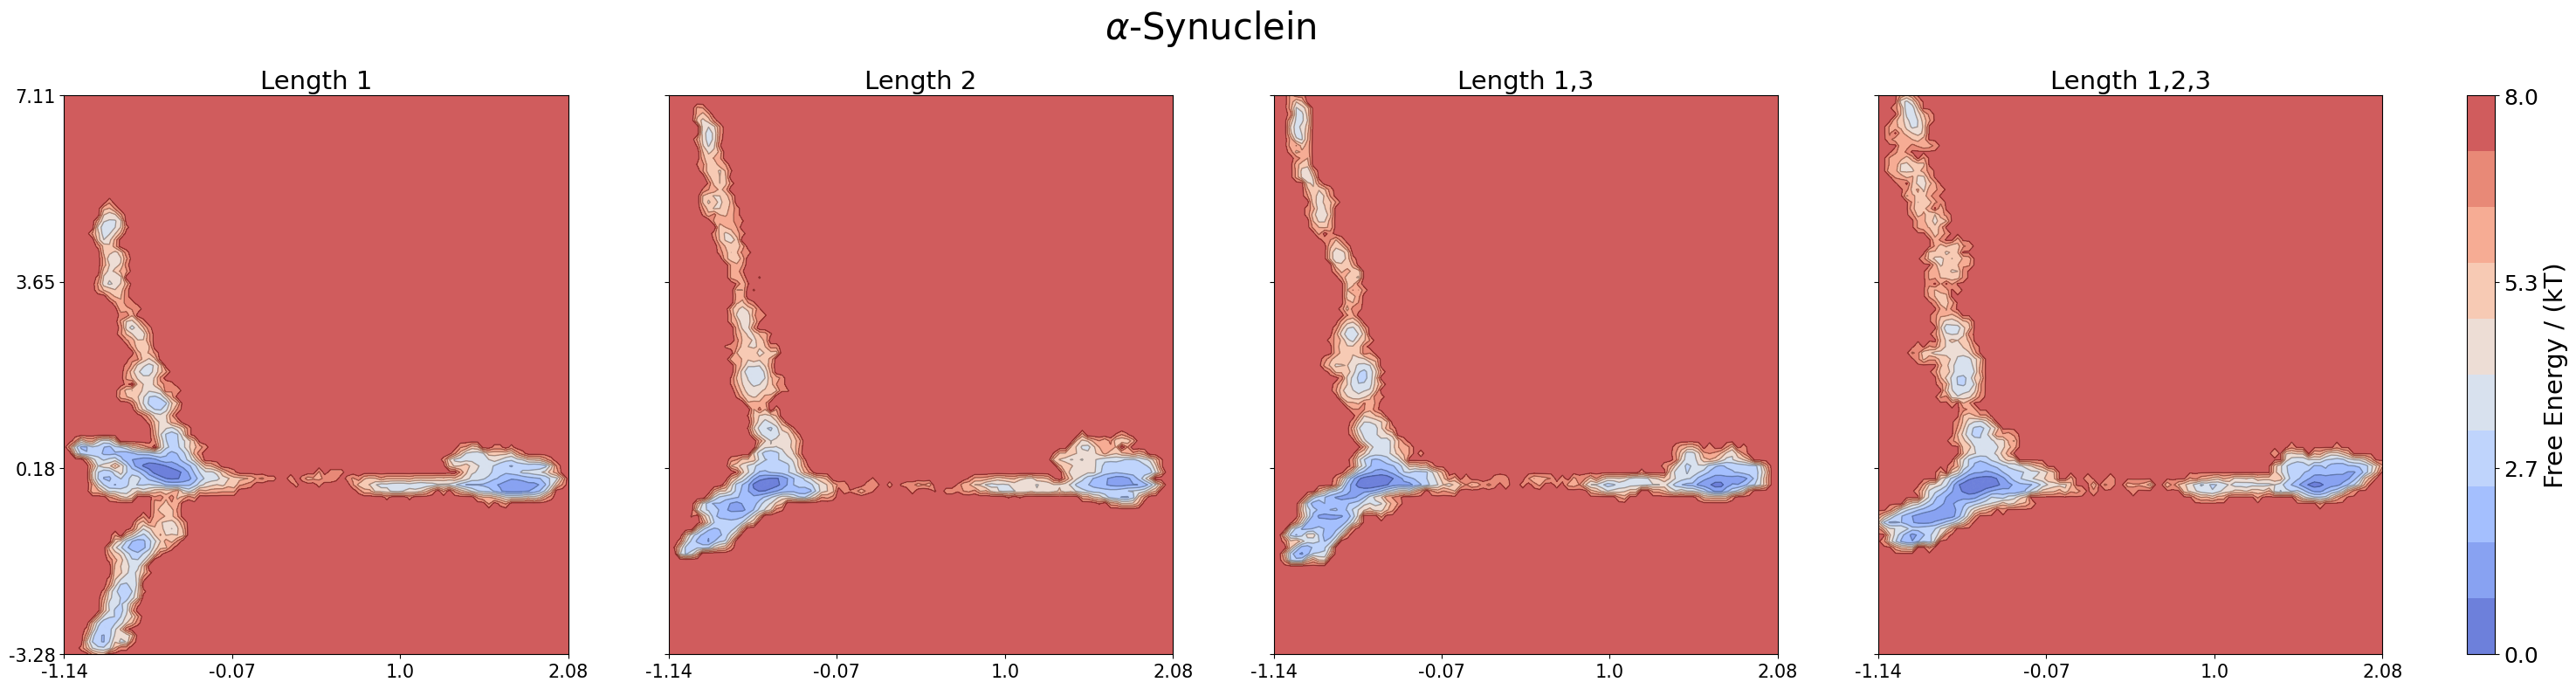

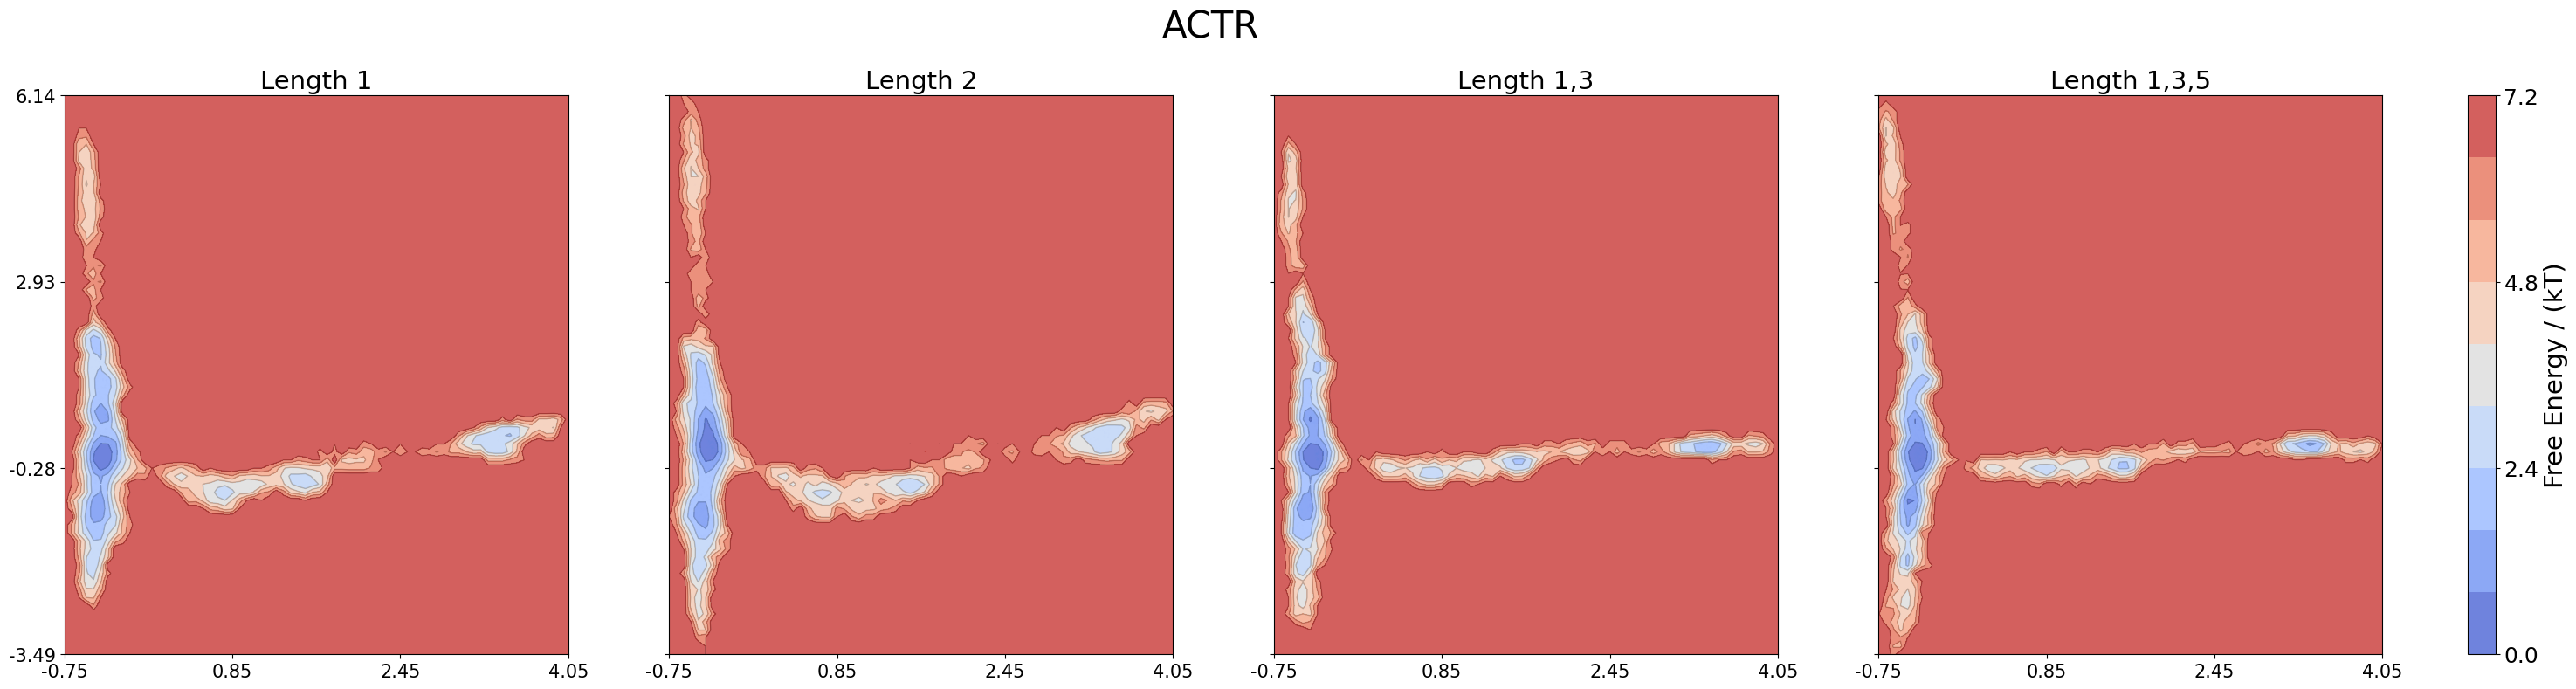

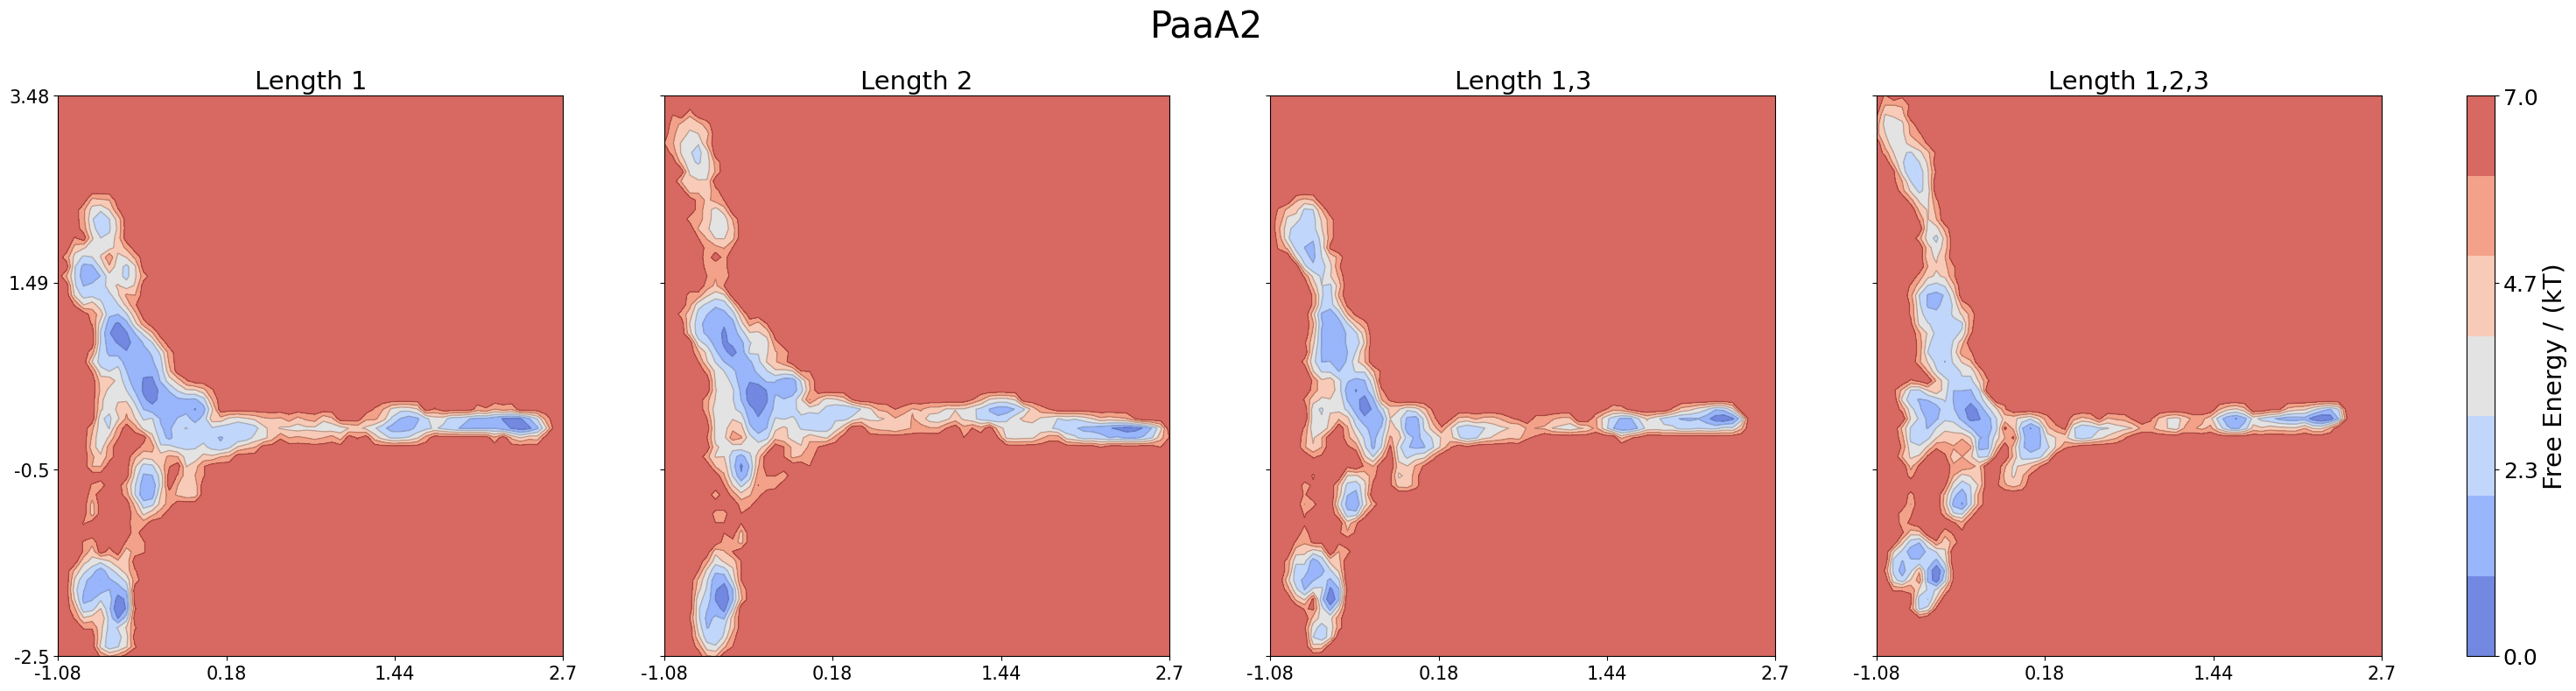

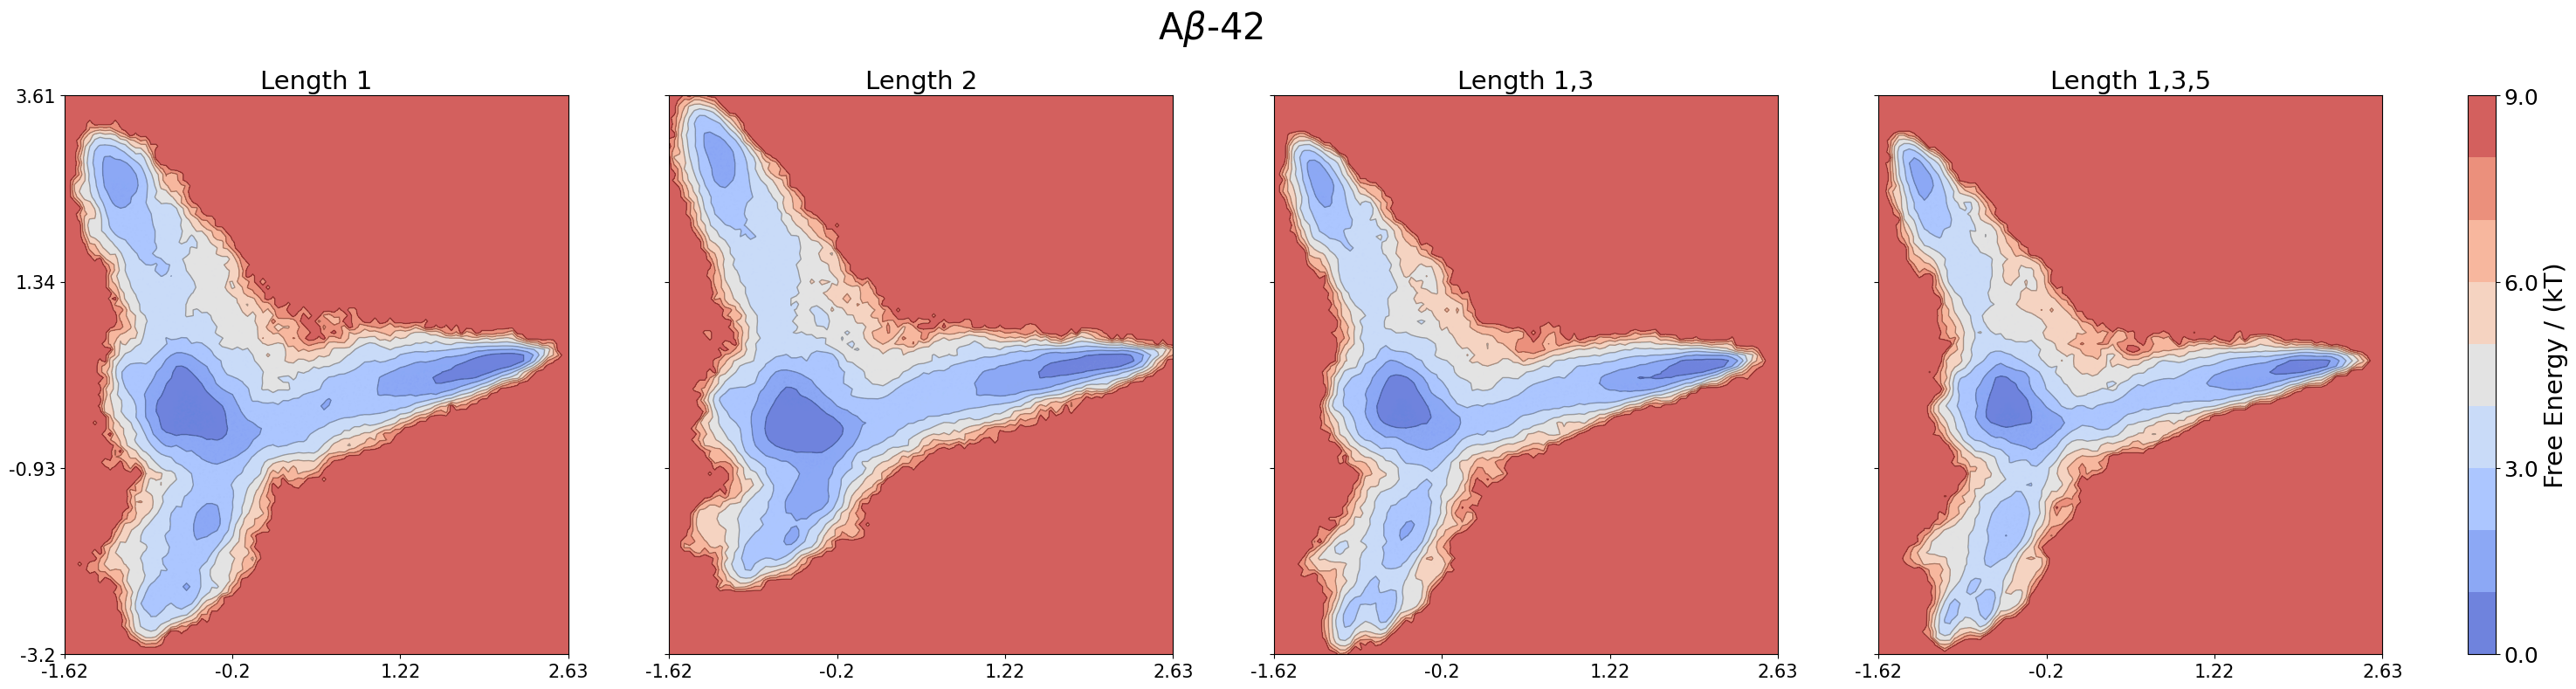

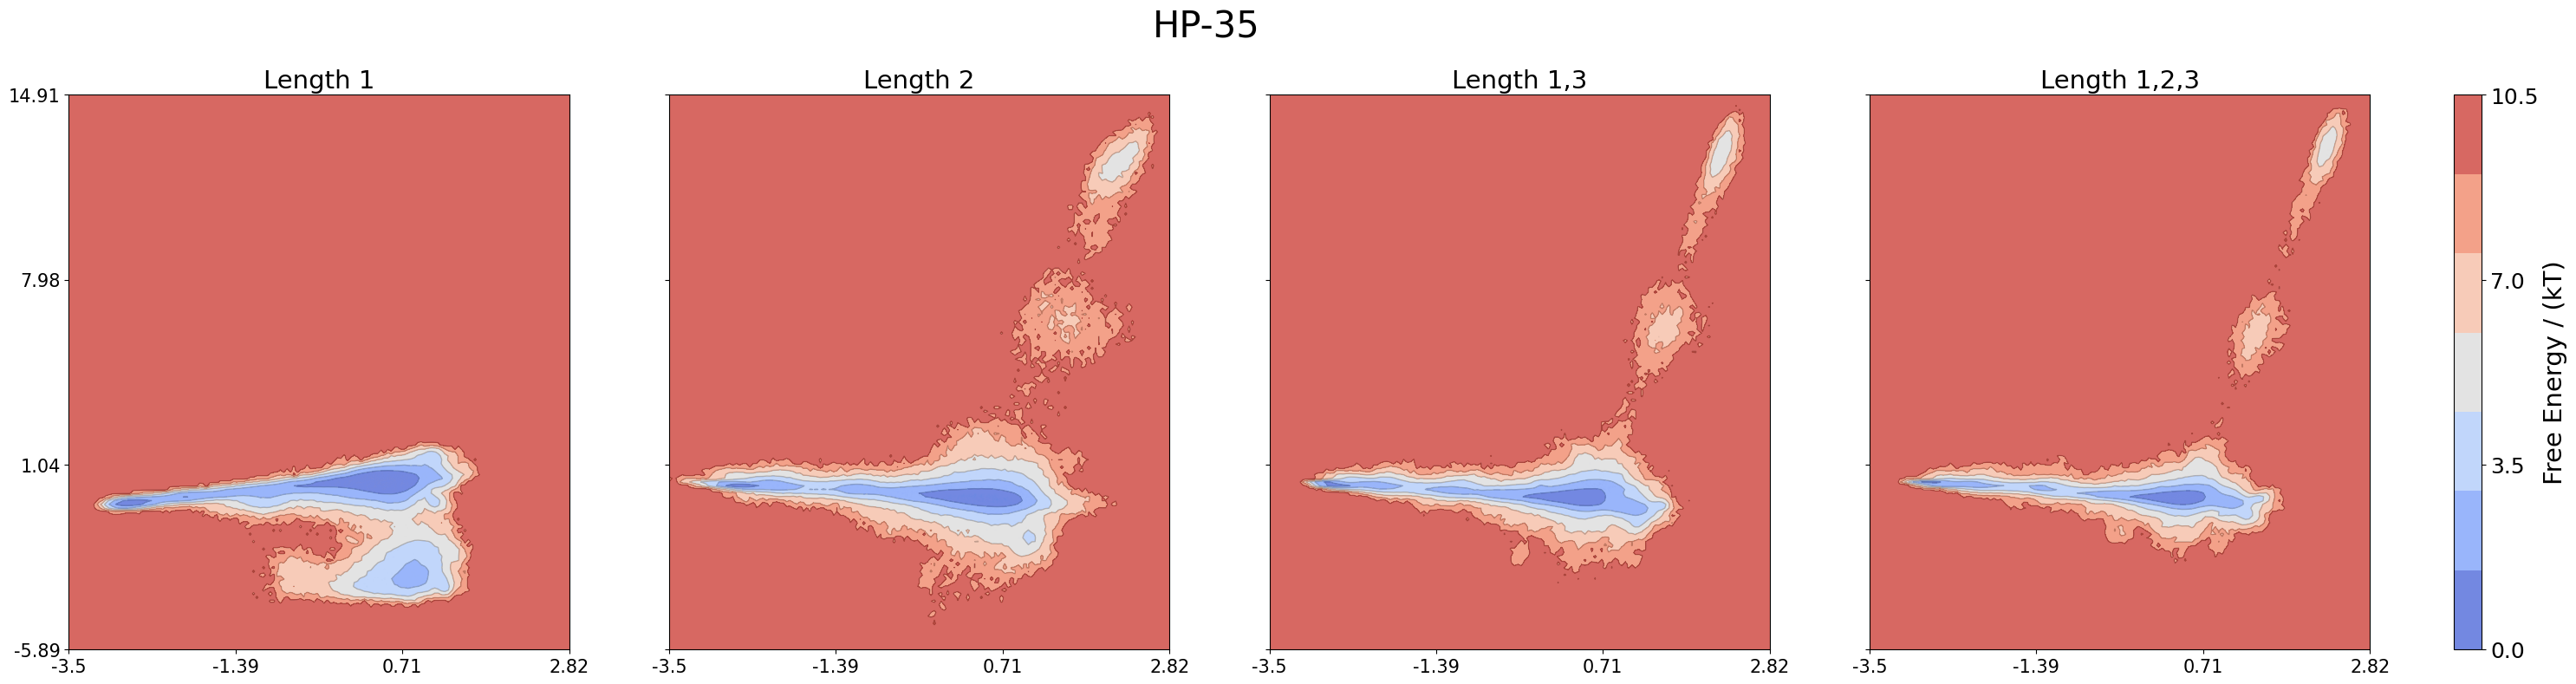

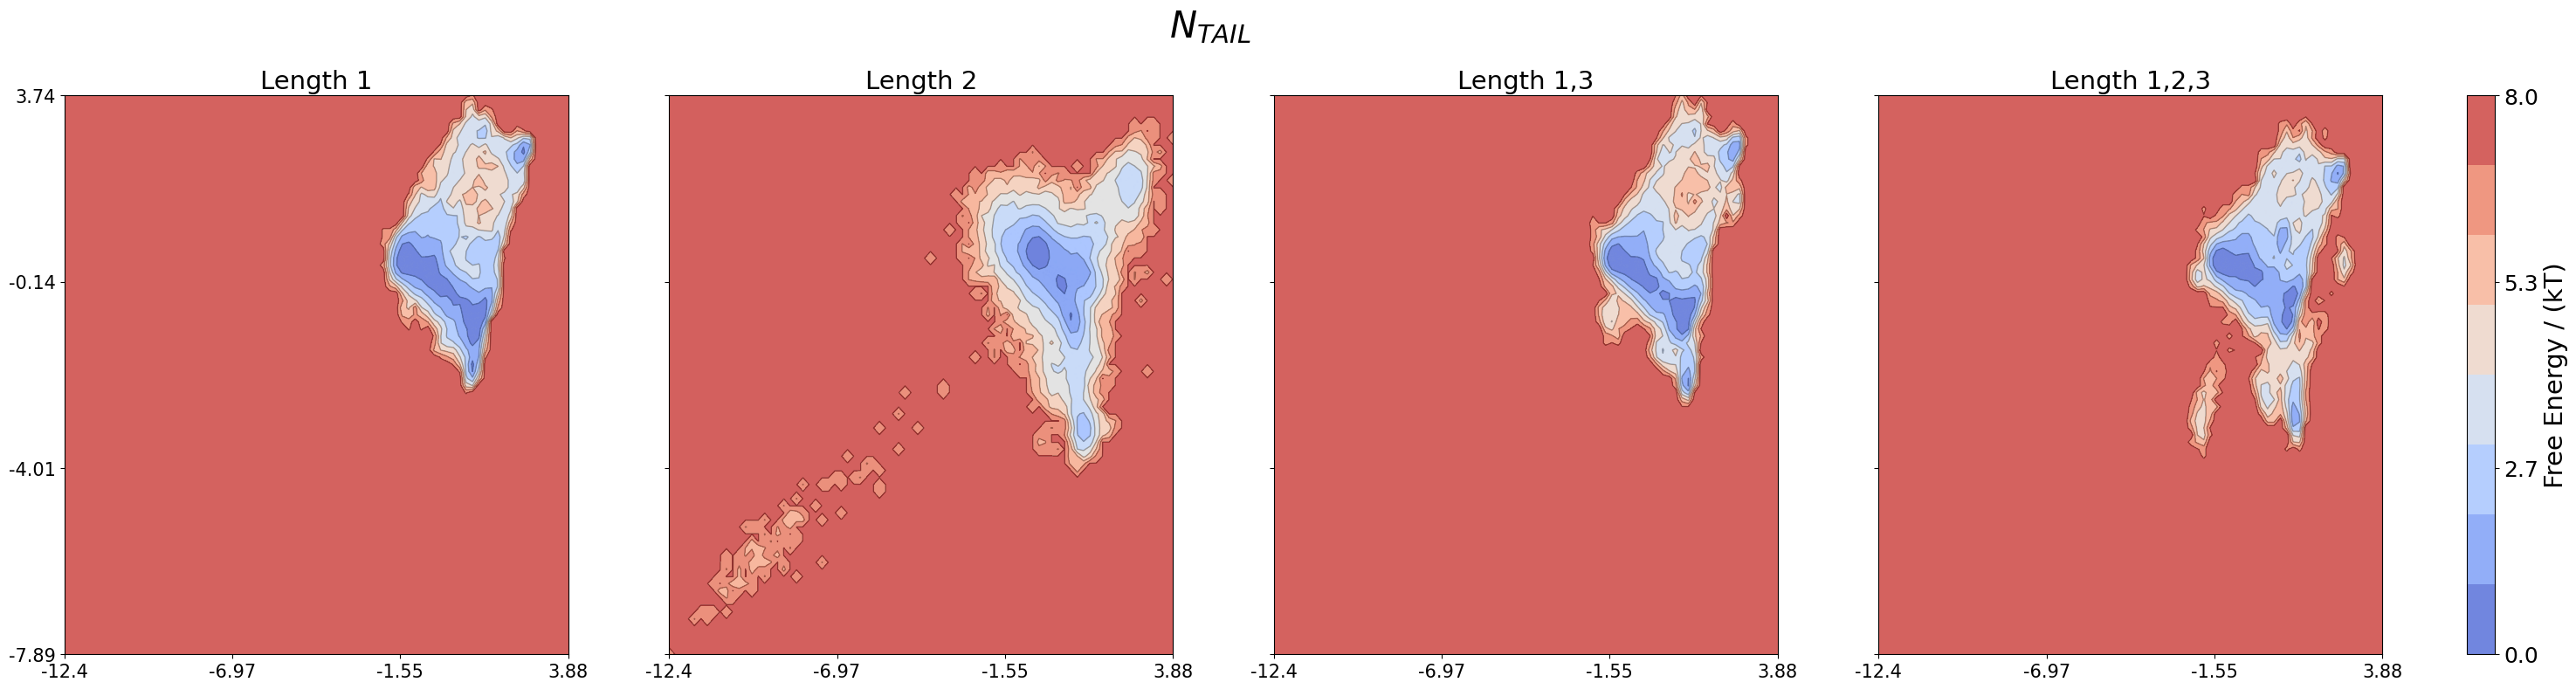

In [347]:
args = dict(mask=False,
            bins=100,
            n_contours=7,
            contour_lines=True,
            alpha_lines=0.4,
            alpha_contours=.8,
            cmap="coolwarm",
            scatter=True,
            scatter_alpha=0.05,
            scatter_cmap="coolwarm_r",
            scatter_min=.86,
            scatter_max=.5,
            scatter_size=0.02,
            font_scale=1.5)
        



for value, name, l, tau, bins, countours, alpha_contours, scatter_scale in\
zip(tcca_projections.values(),
    names,
    lengths,
    lags,
    [90, 70, 60, 100, 150, 80],
    [9, 9, 7, 9, 6, 8],
    [.3,.2,.2,.3,.2,.3],
    [1, .8, .8, 7,1,1],
   ):
    args["bins"] = bins
    args["scatter_stride"] = int(len(value["writhe"][0][:,:2]*1.5) / (scatter_scale * 1000))
    args["n_contours"] = counto1rs
    args["alpha_lines"]=alpha_contours 
    


    proj = np.stack(value["writhe"])[:, :, :2]
    proj = np.stack([rotate_points(proj[2], i, so3=False) for i in proj])
    

    subplots_fes2d(proj,
                   1,
                   4,
                   [f"Length {i}" for i in [1, 2, "1,3", formatter(l)]],
                   figsize=(35, 10),
                   title=name,
                    sharey=True,
                   title_pad=.92,
                    **args)

    
    
    
    # subplots_proj2d(proj, 

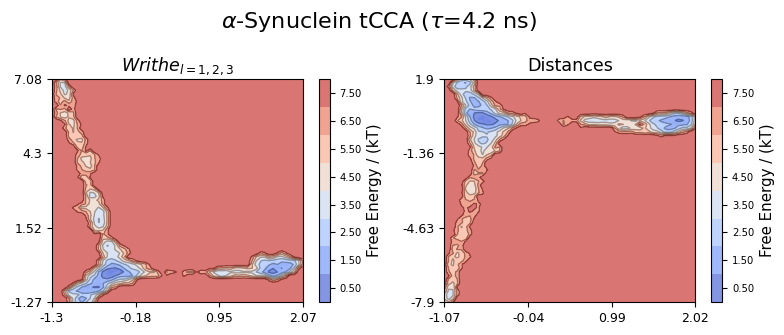

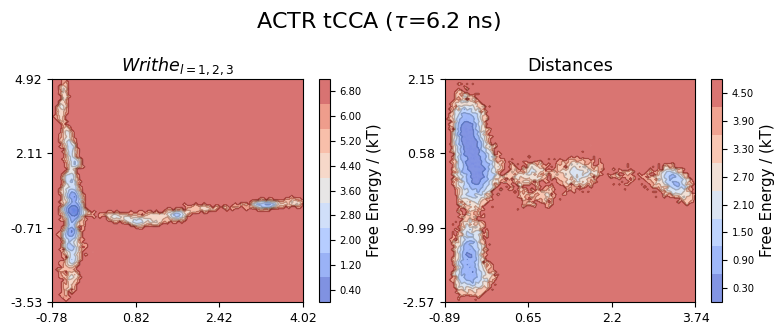

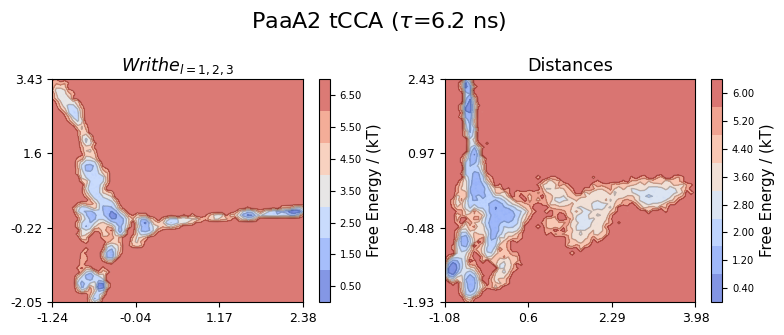

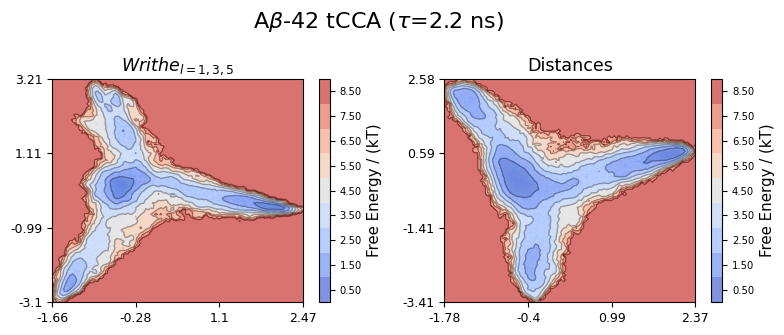

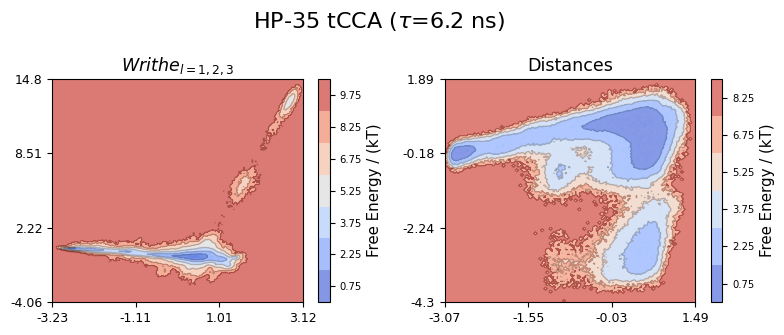

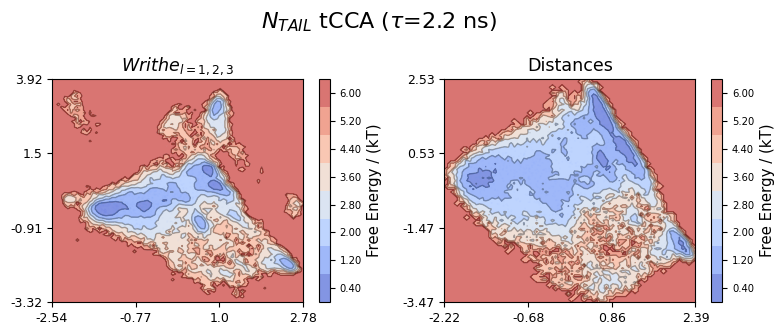

In [65]:
args = dict(mask=False,
            bins=100,
            n_contours=7,
            contour_lines=True,
            alpha_lines=0.4,
            alpha_contours=.7,
            cmap="coolwarm",
            scatter=True,
            scatter_alpha=0.15,
            scatter_cmap="coolwarm_r",
            scatter_min=.86,
            scatter_max=.5,
            scatter_size=0.02
        
            )

for value, name, l, tau, bins, countours, alpha_contours, scatter_scale in\
zip(tcca_projections.values(),
    names,
    lengths,
    lags,
    [60, 90, 60, 100, 150, 80],
    [7, 8, 7, 9, 6, 8],
    [.3,.2,.2,.3,.2,.3],
    [1, .8, .8, 7,1,1]
   ):
    args["bins"] = bins
    args["scatter_stride"] = int(len(value["writhe"][0][:,:2]*1.5) / (scatter_scale * 1000))
    args["n_contours"] = countours
    args["alpha_lines"]=alpha_contours  
    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    ax = axes.flat    
    l = str(l)
    fes2d(value["writhe"][-1][:,:2],
          ax=ax[0],
          font_scale=.9,
          title=f"$Writhe$$_{{l={','.join(l) if len(l) > 1 else l}}}$",
          **args)
    
    fes2d(rotate_points(value["writhe"][-1][:,:2], value["distances"][:,:2]),
          ax=ax[1],
          font_scale=.9,
          title="Distances",
          **args
         )
    
    fig.tight_layout()
    fig.suptitle(name + f" tCCA (${symbols('tau')}$={tau *.2 :.1f} ns)", x=.48, y = 1.10,size=16)
    #plt.savefig(f"./{name}_projection_plot", dpi=1200, bbox_inches="tight")

 ### General loop for clustering and timescale estimation for all systems.
 
 ### Running clustering and timescale estimation for all systems is expensive.
 
 ### We load previous results in the cell after next

In [417]:
cluster = {}
times = {}
ks = [10, 20, 40]
ds = [2, 3, 5, 10]
ranges = [np.arange(1, 12) * 8,
          np.arange(1, 12) * 5, 
          np.arange(1, 12) * 5,
          np.arange(1, 12) * 8,
          np.arange(5, 550, 50),
          np.arange(1, 12) * 8,
         ]

for key, steps in zip(proteins, ranges):
    print(key)

    cluster[key] = {'writhe': {}, 'distances':{}}
    times[key] = {'writhe': {}, 'distances':{}}
    
    for k in ks:
        # for d in ds:

        cluster[key]['writhe'][k] = {d : Kmeans(tcca_projections[key]['writhe'][-1], k, d, n_init=100, max_iter=1000)[0]
                                         for d in ds}
                
        cluster[key]['distances'][k] = {d : Kmeans(tcca_projections[key]['distances'], k, d, n_init=100, max_iter=1000)[0]
                                       for d in ds}

        times[key]['writhe'][k] = {d : iter_longest_timescale(cluster[key]['writhe'][k][d] if key != 'ab42'
                                                          else np.split(cluster[key]['writhe'][k][d], split),
                                                          lagtimes=steps,
                                                          bayes=True)
                                      for d in cluster[key]['writhe'][k].keys()}
        
        times[key]['writhe'][k] = {d : iter_longest_timescale(cluster[key]['distances'][k][d] if key != 'ab42'
                                                          else np.split(cluster[key]['writhe'][k][d], split),
                                                          lagtimes=steps,
                                                          bayes=True)
                                      for d in cluster[key]['writhe'][k].keys()}

    

paaa2


/home/t/miniconda3/envs/writhe/lib/python3.10/site-packages/deeptime/markov/tools/analysis/_decomposition.py:496: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


In [33]:
cluster = load_dict("./clusters_asyn123_paa123.pkl") #load_dict("./clusters_123.pkl")
times = load_dict('times_asyn123_paa123.pkl')

In [41]:
import numpy as np
from scipy.stats import zscore

def is_smooth_curve(f, threshold=3.0, method='zscore', verbose=False, jump_cut = 2.0 * (10 / 2) * 1e3):
    """
    Determine if a discretely sampled function is relatively smooth.
    
    Parameters:
        f (array-like): 1D array of sampled function values.
        threshold (float): Threshold for detecting outliers in differences.
        method (str): 'zscore' (default) or 'quantile' for outlier detection.
        verbose (bool): Whether to print a message explaining the result.
    
    Returns:
        bool: True if the curve is smooth, False if discontinuities or jerks are found.
    """
    f = np.asarray(f)

    if f.ndim != 1 or len(f) < 3:
        raise ValueError("Input must be a 1D array with at least 3 values.")

    first_diff = np.diff(f)
    second_diff = np.diff(f, n=2)

    if method == 'zscore':
        first_outliers = np.abs(zscore(first_diff)) > threshold
        second_outliers = np.abs(zscore(second_diff)) > threshold
    elif method == 'jump':
        return not np.any(first_diff > jump_cut)
    elif method == 'quantile':
        def is_outlier(arr):
            q1, q3 = np.percentile(arr, [25, 75])
            iqr = q3 - q1
            lower = q1 - threshold * iqr
            upper = q3 + threshold * iqr
            return (arr < lower) | (arr > upper)

        first_outliers = is_outlier(first_diff)
        second_outliers = is_outlier(second_diff)
    else:
        raise ValueError("Method must be 'zscore' or 'quantile'.")

    has_outliers = np.any(first_outliers) or np.any(second_outliers)

    if verbose:
        if has_outliers:
            print("⚠️ Function appears to have discontinuities or sharp curvature.")
        else:
            print("✅ Function appears relatively smooth.")

    return not has_outliers

asyn
actr


/home/t/writhe/Writhe_Package_Lite/src/writhe_tools/plots.py:297: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  if len(list(filter(None, (ymin, ymax)))) != 0: ax.set_ylim(ymin, ymax)
/tmp/ipykernel_22140/1635961139.py:100: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axe.set_ylim(ymax=ymax, ymin=0)


paaa2
ab42
hp35


/home/t/writhe/Writhe_Package_Lite/src/writhe_tools/plots.py:297: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  if len(list(filter(None, (ymin, ymax)))) != 0: ax.set_ylim(ymin, ymax)
/tmp/ipykernel_22140/1635961139.py:100: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axe.set_ylim(ymax=ymax, ymin=0)
/tmp/ipykernel_22140/1635961139.py:100: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axe.set_ylim(ymax=ymax, ymin=0)
/tmp/ipykernel_22140/1635961139.py:100: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axe.set_ylim(ymax=ymax, ymin=0)
/tmp/ipykernel_22140/1635961139.py:100: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axe.set_ylim(ymax=ymax, ymin=0)
/tmp/ipykernel_22140/1635961139.py:100: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axe.set_ylim(ymax=y

ntail


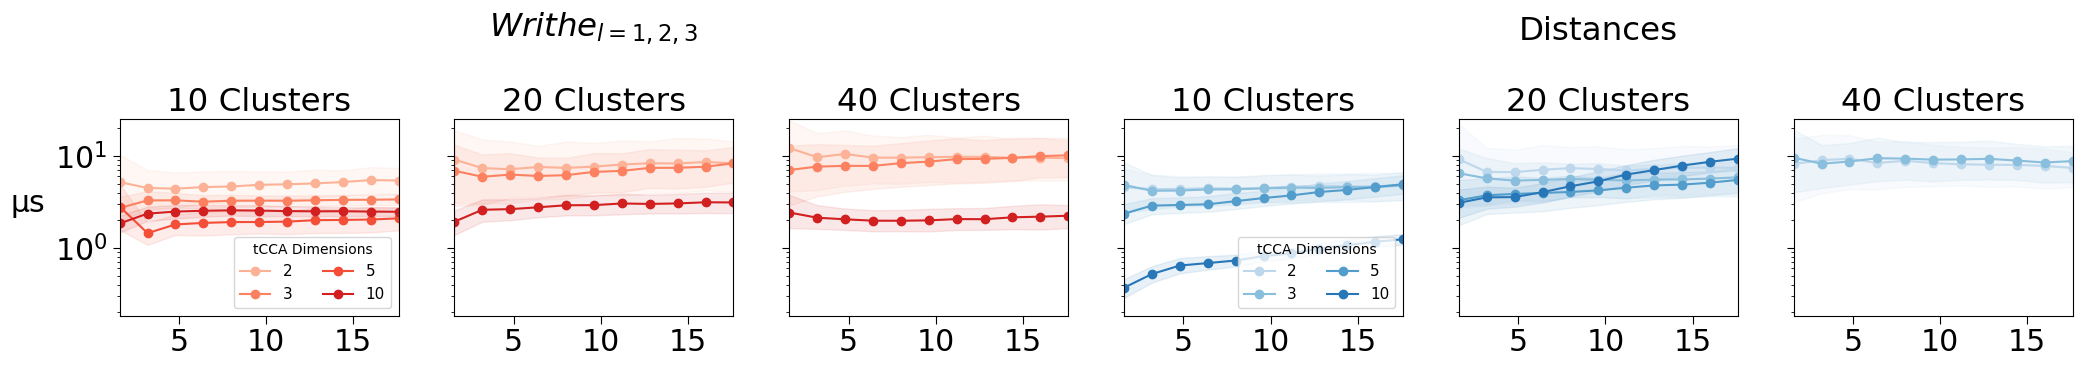

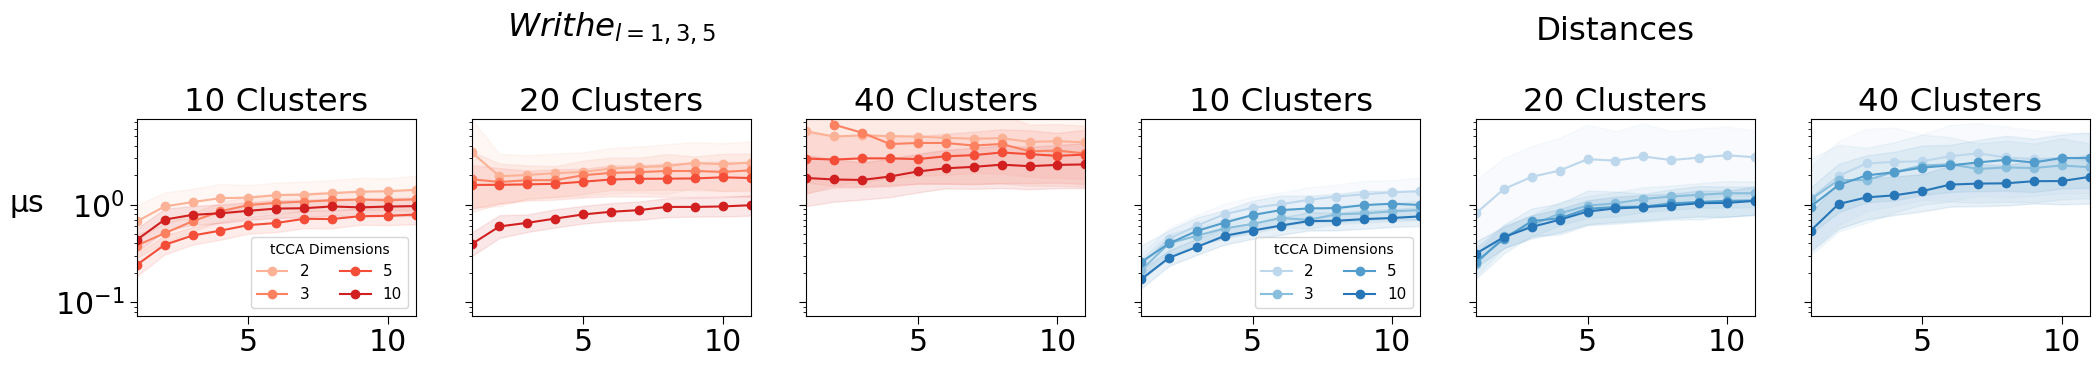

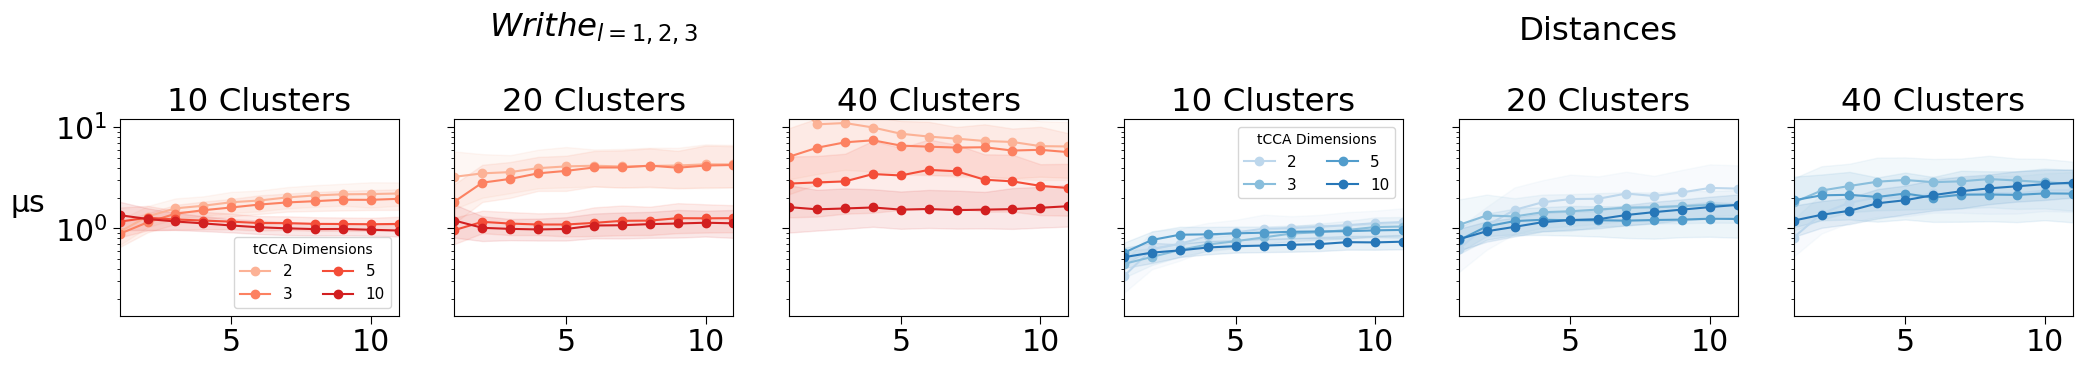

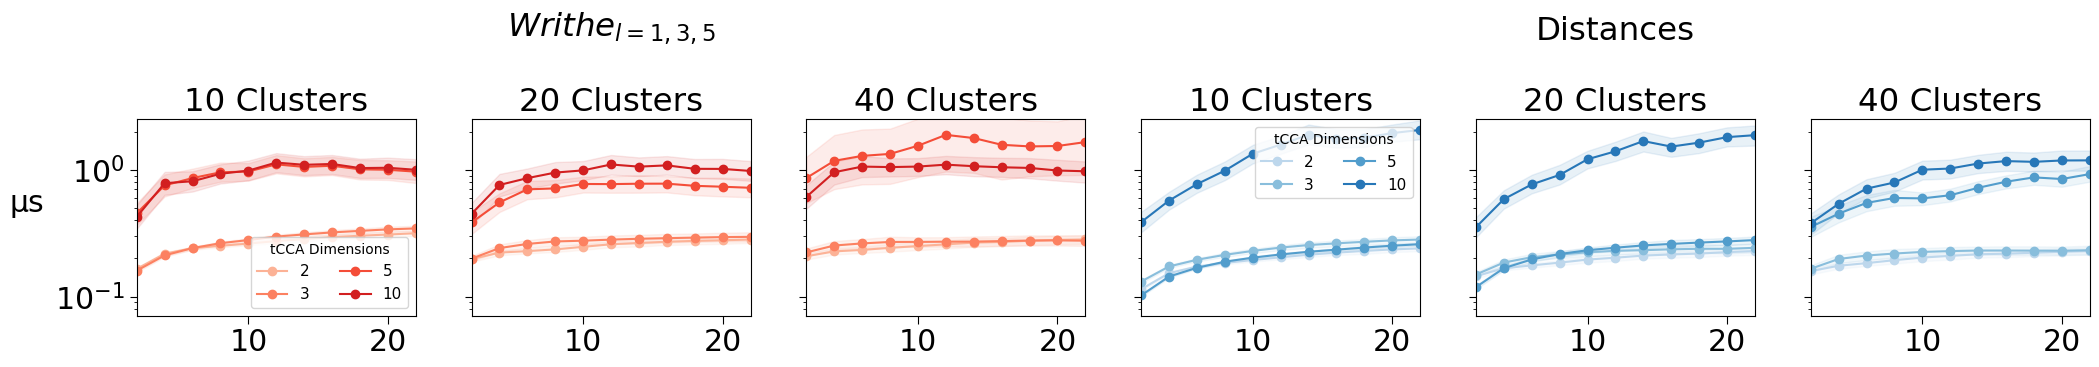

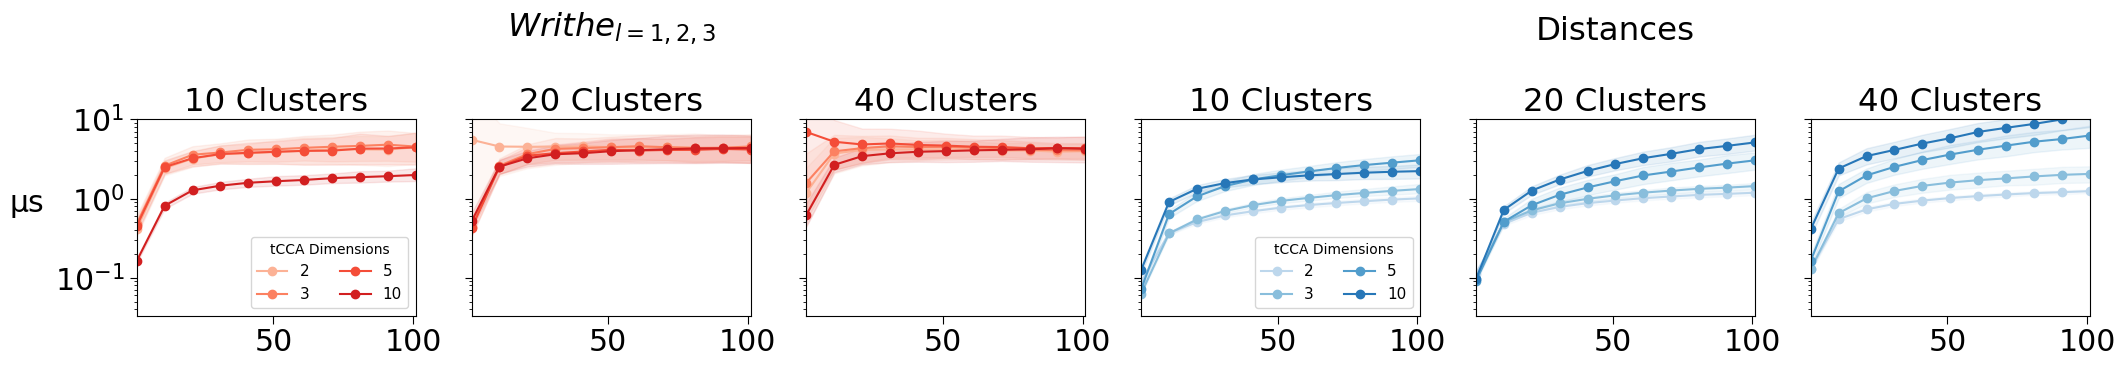

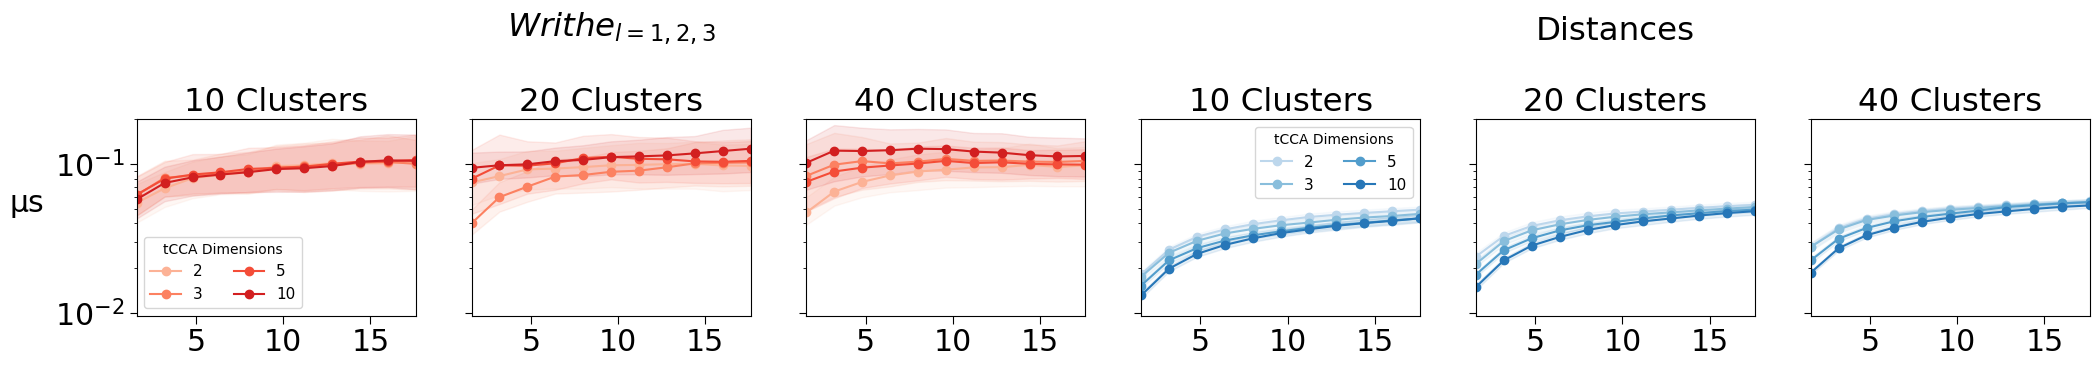

In [42]:
ranges = [np.arange(1, 12) * 8,
          np.arange(1, 12) * 5, 
          np.arange(1, 12) * 5,
          np.arange(1, 12) * 8,
          np.arange(5, 550, 50),
          np.arange(1, 12) * 8,
         ]

for key, steps, ymax, l in zip(proteins,
                               ranges,
                               [25, 7.5, 12, 2.5, 10, .2],
                               lengths,
                              
                              ):
    
    
    # steps = np.arange(1, 12) * 5 if not key in ('hp35', 'asyn', 'ntail') else np.arange(5, 550, 50)\
    #         if key =='hp35' else np.arange(1, 12) * 25
    ks = [10, 20 , 40,]# 60, 80, 100] # 60, 80]# 60]#, 80, 100] # number of clusters
    ds = [2, 3, 5, 10] # 8, 10] # number of dimensions
    fig, axes = plt.subplots(1,
                             6,
                             figsize=(len(ks) * 8.4, 3.4 * 1.5 / 2),
                             sharex=False,
                             sharey=True)
    if key == "hp35":
        method = "zscore"
    else:
        method = "jump"

    dt = 0.25 if (key == "ab42") else 0.2
    
    
    print(key)

    axes_ = [[axes[i], axes[i+3]] for i in range(3)]

    for k, ax in zip(ks, axes_):
        
        
        # ax[0].set_title((rf"$Writhe_{{{formatter(l)}}}$\n\n" if k==20 else "") + f"{k} Clusters")
        
        # ax[1].set_title(("Distances\n\n" if k==20 else "") + f"{k} Clusters")

        for d, c1, c2 in zip(ds,
                             writhe_tools.plots.get_color_list(len(ds),
                                                                  "Reds",
                                                                  trunc=70,
                                                                  pre_trunc=70),
                             writhe_tools.plots.get_color_list(len(ds),
                                                                  "Blues",
                                                                  trunc=70,
                                                                  pre_trunc=70),
                            ):


            timescale = [times[key]['writhe'][k][d], times[key]['distances'][k][d]]

            #len(timescale)
            if is_smooth_curve(timescale[0].T[0], method=method):
                lineplot1D(timescale[0].T[0] * 1e-3 * dt,
                           steps * dt,
                           timescale[0].T[1]  * 1e-3 * dt,
                           timescale[0].T[2]  * 1e-3 * dt,
                           fill_color=c1,
                           fill_alpha=0.1,
                           label=d if k == 10 else None,
                           marker='o',
                           ax=ax[0],
                           font_scale=1.8,
                           title=(rf"$Writhe_{{l={formatter(l)}}}$" + "\n\n" if k==20 else "") + f"{k} Clusters",
                           ymax=ymax,
                           color=c1,
                           yscale="log",
                           ylabel=f"{symbols('mu')}s" if k == 10 else "",
                           
                           
                          )
            if is_smooth_curve(timescale[1].T[0], method=method):
                lineplot1D(timescale[1].T[0] * 1e-3 * dt,
                           steps * dt,
                           timescale[1].T[1]  * 1e-3 * dt,
                           timescale[1].T[2]  * 1e-3 * dt,
                           fill_color=c2,
                           fill_alpha=0.1,
                           label=d if k == 10 else None,
                           marker='o',
                           ax=ax[1],
                           font_scale=1.8,
                           title=("Distances\n\n" if k==20 else "") + f"{k} Clusters",
                           ymax=ymax,
                           color=c2,
                           yscale = "log"
                           
                           
                          )
            for axe in ax:
                axe.margins(y=0.1)       # Add vertical margin
                axe.autoscale(enable=True)
                axe.set_ylim(ymax=ymax, ymin=0)
            
            if k==10:
                ax[0].legend(ncol=2,
                             title="tCCA Dimensions",
                             fontsize=11
                             
                            )
                ax[1].legend(ncol=2,
                             title="tCCA Dimensions",
                             fontsize=11
                            )

    #fig.savefig(f"its_{key}.png", dpi=1200, bbox_inches='tight')


In [ ]:
def remove_chunks(data: np.ndarray, split: np.ndarray, remove_indices: list):
    idx = set(range(len(split)+1))
    chunks = np.split(data, split)
    return reindex_list(chunks, list(idx - set(remove_indices)))

dim = 3
lag = 5
k = 40

ab42_dtrajs = np.array_split(cluster['ab42']['writhe'][k][dim], split)
traj_lengths = np.fromiter(map(len, ab42_dtrajs), int)
sort_lengths = traj_lengths.argsort()
ab42_dtrajs = remove_chunks(cluster['ab42']['writhe'][k][dim],
                            split, 
                            sort_lengths[:200].tolist())


# to rerun
# counts = deeptime.markov.TransitionCountEstimator(lagtime=lag, count_mode="effective").fit(ab42_dtrajs).fetch_model()
# bmsm = deeptime.markov.msm.BayesianMSM(n_samples=1000).fit(counts).fetch_model()

bmsm = load_dict("ab42_bmsm.pkl")

assignments = bmsm.samples[0].pcca(5).assignments
cg_dtraj = assignments[np.concatenate(ab42_dtrajs)].astype(int)

proj2d(np.concatenate(remove_chunks(tcca_projections['ab42']['writhe'][-1][:, :2],
                     split,
                     sort_lengths[:200].tolist())),
       c = cg_dtraj, state_map="True", cmap="coolwarm")


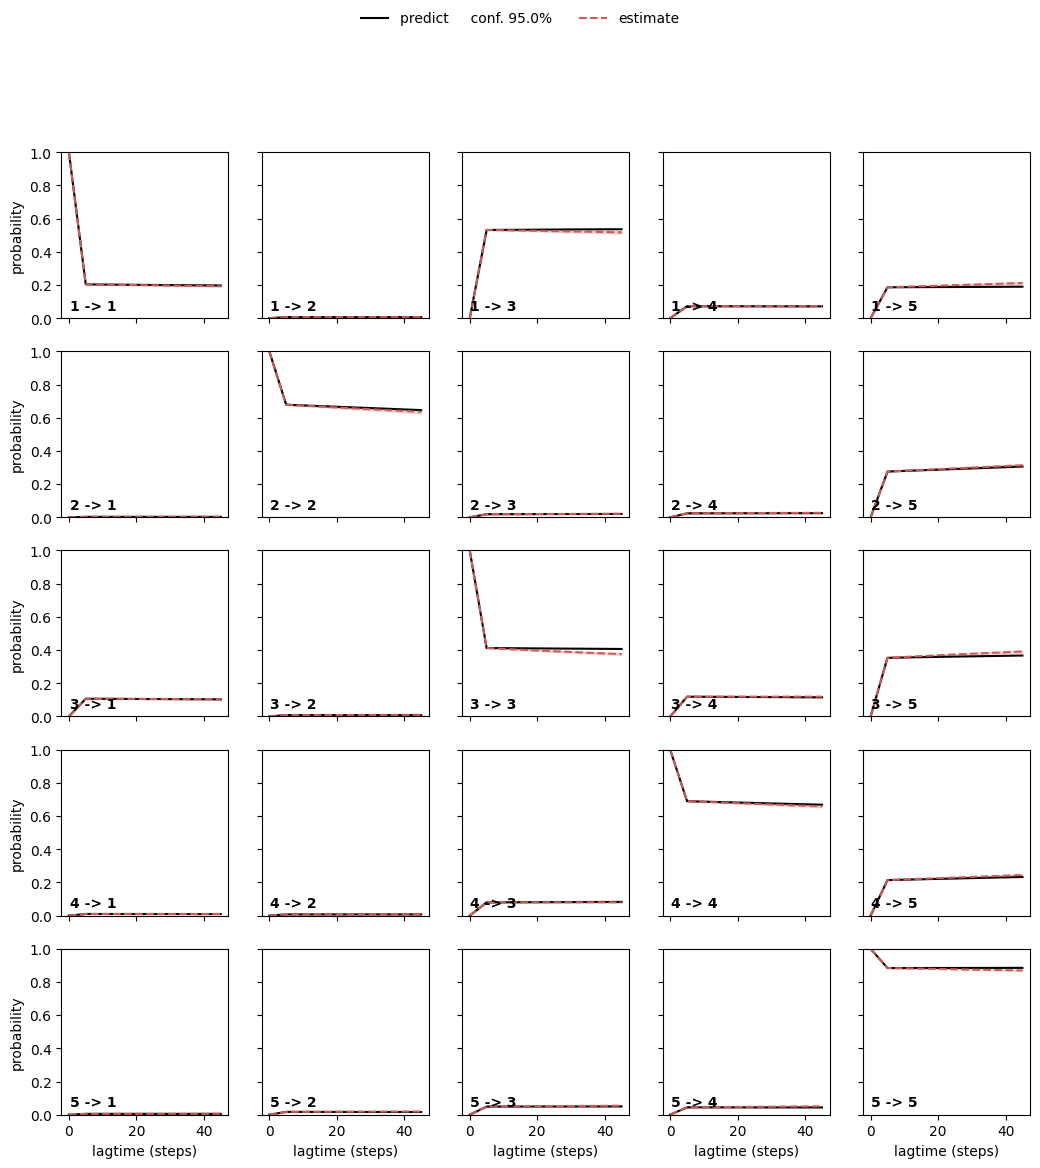

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.util.validation import ck_test
from deeptime.markov.msm import BayesianMSM
# Example: assume you have a list of discrete trajectories (list of 1D numpy arrays)
# Replace this with your real clustered data


# Fit MSM at base lag time
lagtime = 5
  # multiples of base lag time
counter = lambda x,lag : deeptime.markov.TransitionCountEstimator(lagtime=int(lag),
                                                              count_mode="effective"
                                                             ).fit(x).fetch_model()
# to rerun
#msms = [BayesianMSM(n_samples=5000).fit(counter(ab42_dtrajs, lagtime * t)).fetch_model() for t in range(1, 10)]

msms = load_dict("./ab42_bmsms.pkl")

# Perform Chapman-Kolmogorov test with bootstrap error estimation
ck_test = msms[0].ck_test(msms, n_metastable_sets=5, err_est=False)
ck_test.plot(color="indianred")

/tmp/ipykernel_22140/2739677372.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels((np.arange(1, 10) * 5 * 0.25))


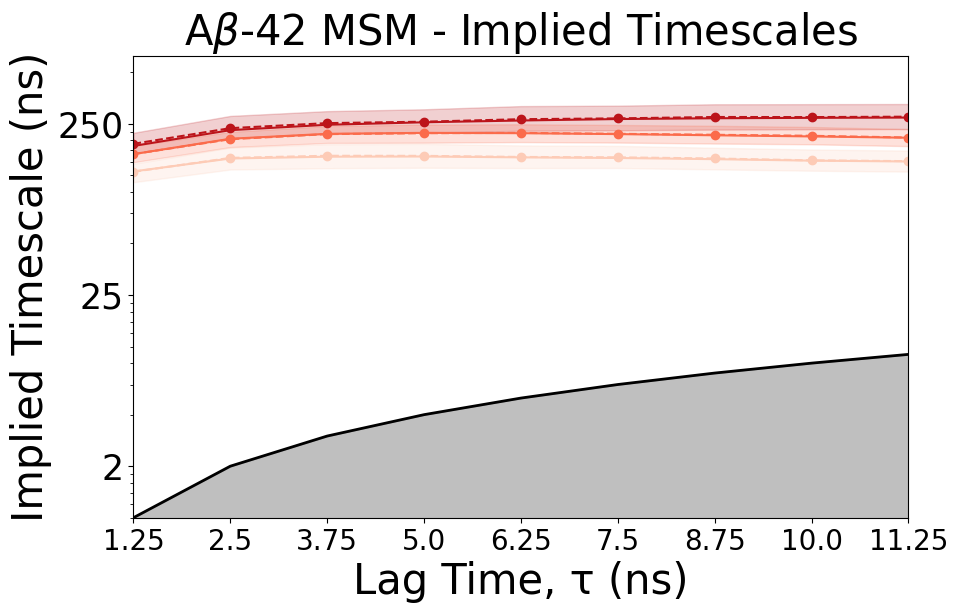

In [46]:
import matplotlib.ticker as ticker
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales

its = implied_timescales(msms)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_yscale("log")
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x * 0.25:.0f}"))
plot_implied_timescales(its,
                        ax=ax,
                        colors = get_color_list(3, 'Reds_r', 50, 50),
                        n_its=3)
ax.set_xticklabels((np.arange(1, 10) * 5 * 0.25))
#ax.set_xlim(5, 15)
ax.set_ylabel("Implied Timescale (ns)", size=30)
ax.set_xlabel(f"Lag Time, {symbols('tau')} (ns)", size=30)
plt.title(r"A$\beta$-42 MSM - Implied Timescales",size = 30)
ax.tick_params('both', labelsize = 25)
ax.tick_params('x', labelsize = 20)
ax.set_xlim(5, 45)
ax.set_ylim(5, 2500)
fig.savefig("ab42_its.png", dpi=1000, bbox_inches='tight')

In [3]:
bmsm = load_dict("ab42_bmsm.pkl")
reassignments = np.array([3,4,2,1,0])
idx = np.array([4, 3, 2, 0, 1])
n_states = 5
assignments = bmsm.samples[0].pcca(5).assignments
sets = bmsm.samples[0].pcca(5).sets

for i in range(0,30):
    assignments = bmsm.samples[i].pcca(5).assignments
    cg_dtraj = assignments[np.concatenate(ab42_dtrajs)].astype(int)
    stride = 1000
    proj2d(np.concatenate(remove_chunks(tcca_projections['ab42']['writhe'][-1][:, :2],
                         split,
                         sort_lengths[:200].tolist()))[::stride],
           c = cg_dtraj[::stride], state_map="True", cmap="coolwarm")
    

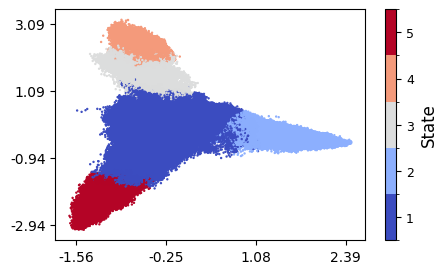

In [166]:
tcca = np.concatenate(remove_chunks(tcca_projections['ab42']['writhe'][-1][:, :2],
                     split,
                     sort_lengths[:200].tolist()))


proj2d(tcca,
       c = reassignments[cg_dtraj],
       state_map="True",
       cmap="coolwarm")

In [17]:
state_counts = np.fromiter(map(lambda x : len(np.unique(x)), [i.pcca(5).assignments for i in bmsm.samples]), int)

In [18]:
pi_group = group_by(assignments, values=bmsm.evaluate_samples("stationary_distribution")[np.where(state_counts==5)].mean(0))
err_L = np.array([np.sqrt((k**2).sum()) for k in [abs(i - j) for i, j in 
         zip(pi_group,
             group_by(assignments, values=bmsm.gather_stats("stationary_distribution", confidence=0.95).L)
            )]])
err_R = np.array([np.sqrt((k**2).sum()) for k in [abs(i - j) for i, j in 
         zip(pi_group,
             group_by(assignments, values=bmsm.gather_stats("stationary_distribution", confidence=0.95).R)
            )]])

pi_err = (err_L + err_R) / 2

pi_mu = np.fromiter(map(np.sum, pi_group), float)
pi_mu * 100

array([ 2.04885525,  2.99256332,  6.15597469, 12.55891092, 76.24369582])

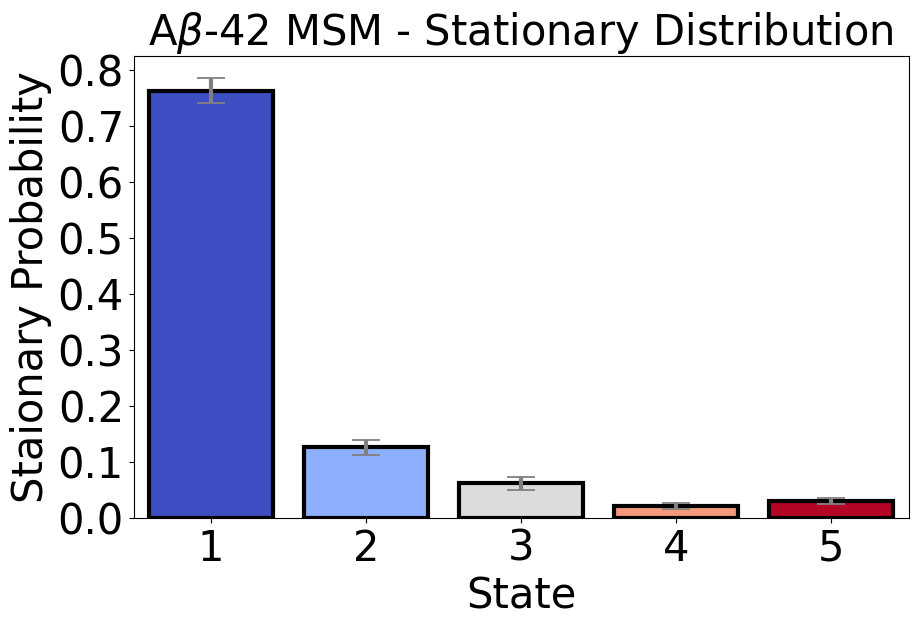

In [171]:
from writhe_tools.plots import box_plot, get_color_list
n_states = 5
clist = get_color_list(n_states, "coolwarm")#, trunc=80, pre_trunc=80)
plt.figure(figsize = (10,6))
plt.bar(np.arange(1,n_states+1),pi_mu[idx],yerr = pi_err[idx],
        ecolor="grey",color=clist,capsize=10,width=.8,linewidth=3, edgecolor = "black",
        align="center",error_kw=dict(capthick=1.3,lw=3))
plt.xticks(np.arange(1,n_states+1), np.arange(1,n_states+1))
plt.xlabel("State", size=30)
plt.ylabel("Staionary Probability", size=30)
plt.title(r"A$\beta$-42 MSM - Stationary Distribution",size = 30)
plt.xticks(size = 30)
plt.yticks(size = 30)
plt.xlim(.5,n_states + .5)
plt.savefig("stat.png", dpi=1000, bbox_inches='tight')

In [173]:
from writhe_tools.plots import annotated_matrix_plot

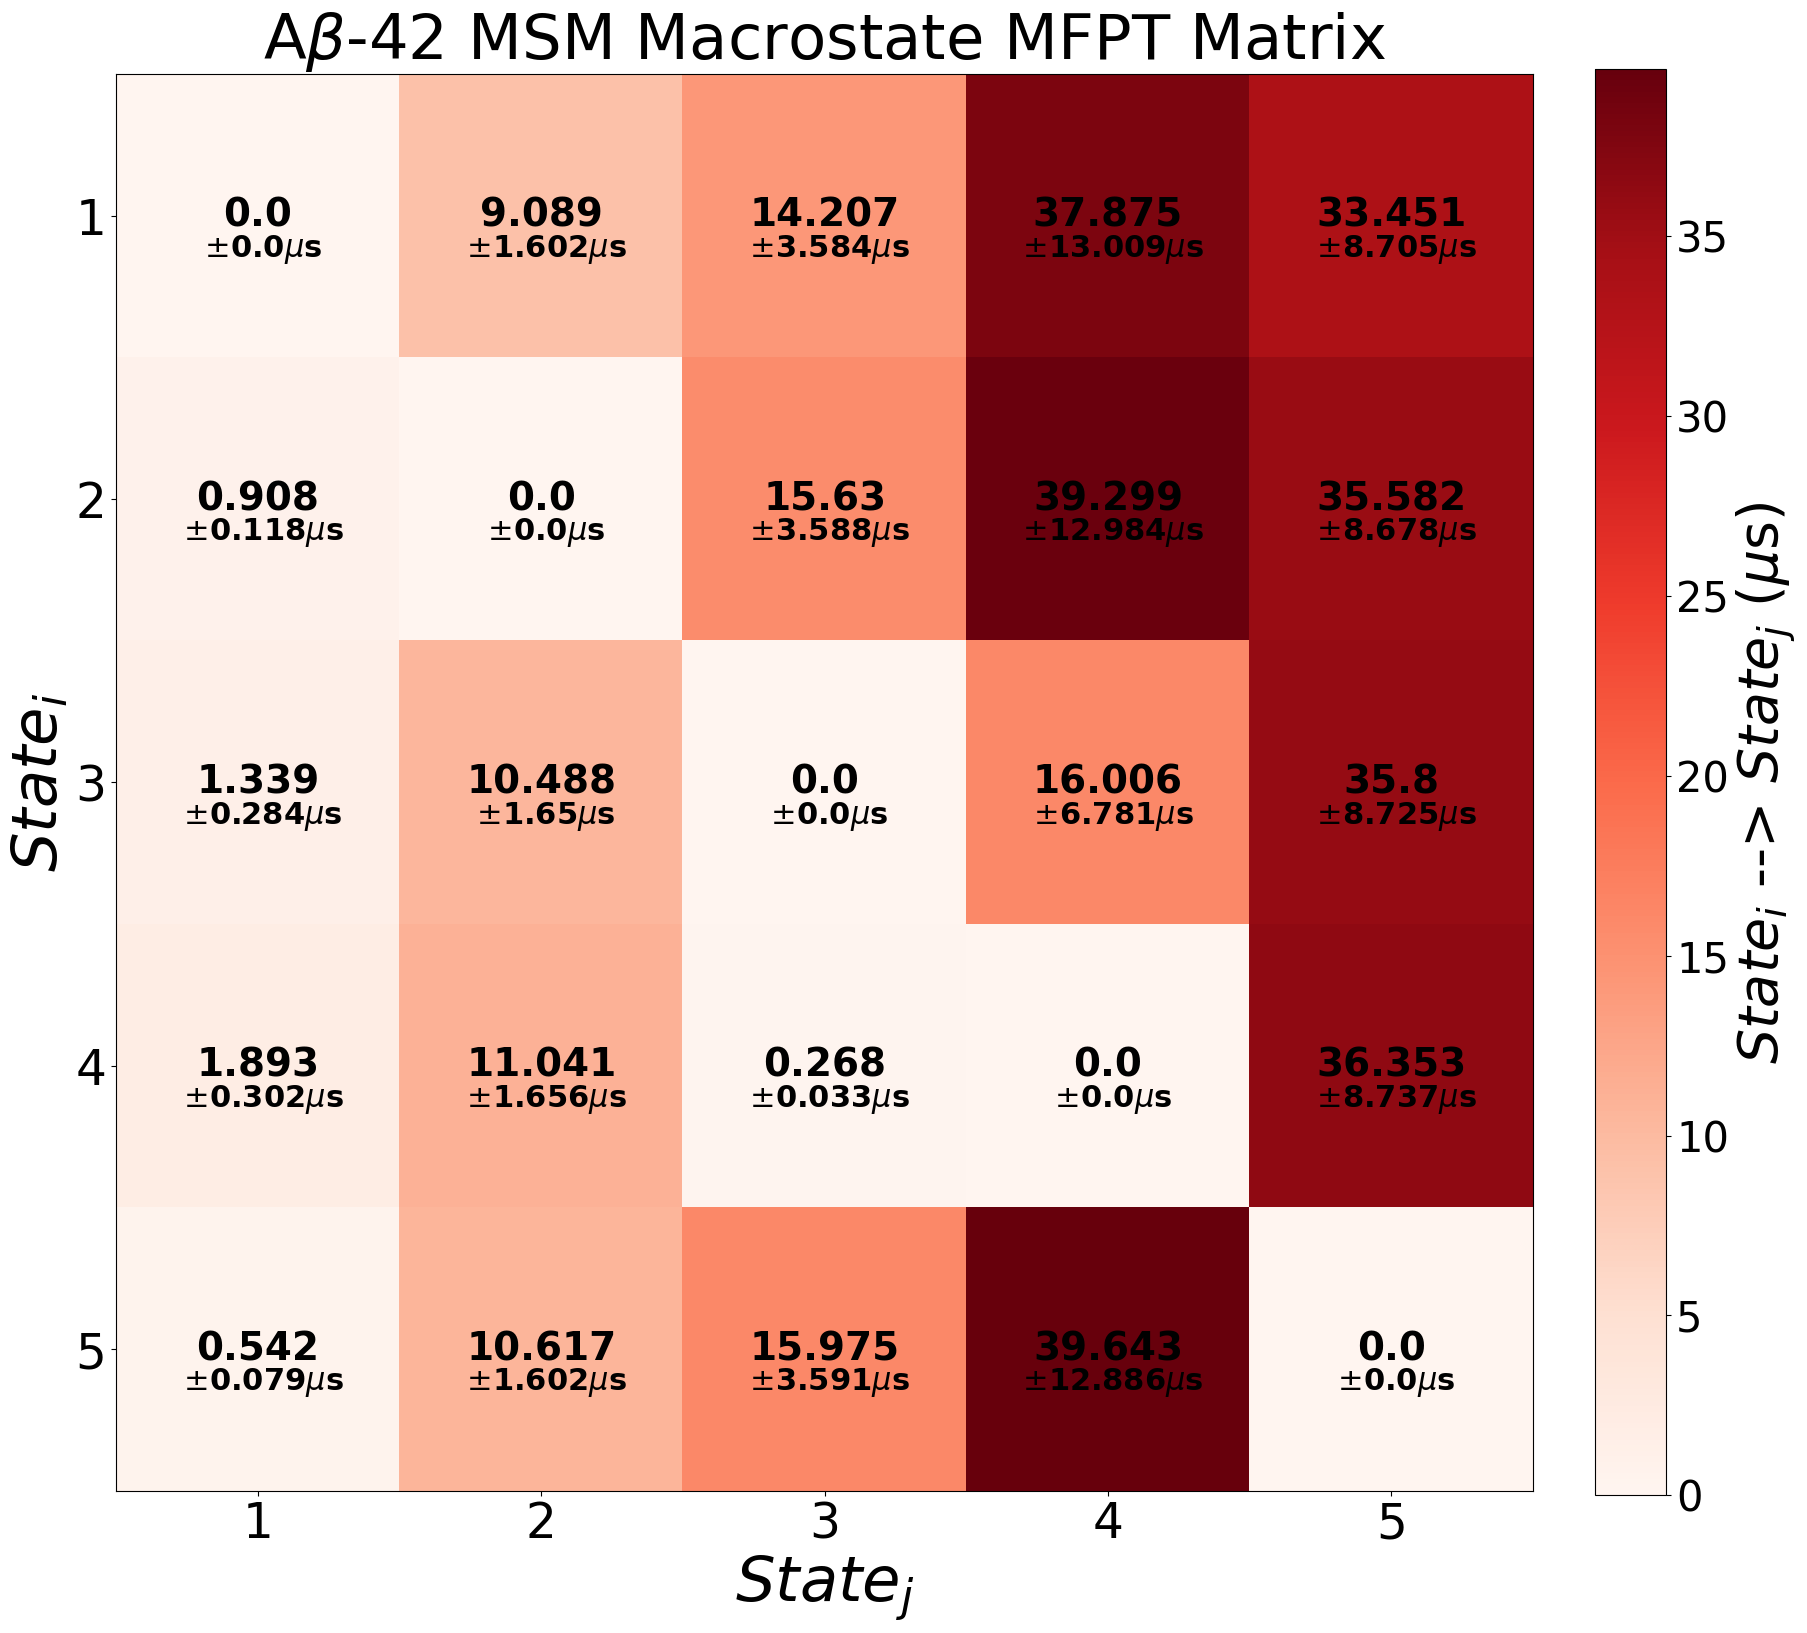

In [174]:
sets = bmsm.samples[0].pcca(5).sets
mfpt = np.zeros((n_states, n_states))
mfpt_err = np.zeros((n_states, n_states))
for i in range(n_states):
    for j in range(n_states):
        mean = bmsm.gather_stats("mfpt",
                                 A=sets[i],
                                 B=sets[j]
                                      ).mean
        mfpt[i, j] = mean
        stats = bmsm.gather_stats("mfpt",
                                  A=sets[i],
                                   B= sets[j],
                                  confidence=0.95
                                      )
        l, r = stats.L, stats.R
        mfpt_err[i, j] = .5 * (abs(mean-l)+ abs(mean-r))

mfpt, mfpt_err = [reindex_matrix(i, idx) for i in (mfpt, mfpt_err)]
        

annotated_matrix_plot(matrix = mfpt * 0.25 * 10 * 1e-3,
               error_matrix = mfpt_err * 0.25 * 10 * 1e-3,
               title = r"A$\beta$-42 MSM Macrostate MFPT Matrix",
               unit = r"$\mu$s",
               cbar_label = r"$State_{i}$ --> $State_{j}$ ($\mu$s)",
               val_text_size = 28,
               err_text_size = 22,
               textcolor = "black",
                      alpha=1,
               cmap = "Reds",
               tick_labels = np.arange(1, n_states+1),
               decimals=3,
               #clims=(0, ),
              )
plt.savefig("mfpt.png", dpi=1000, bbox_inches='tight')

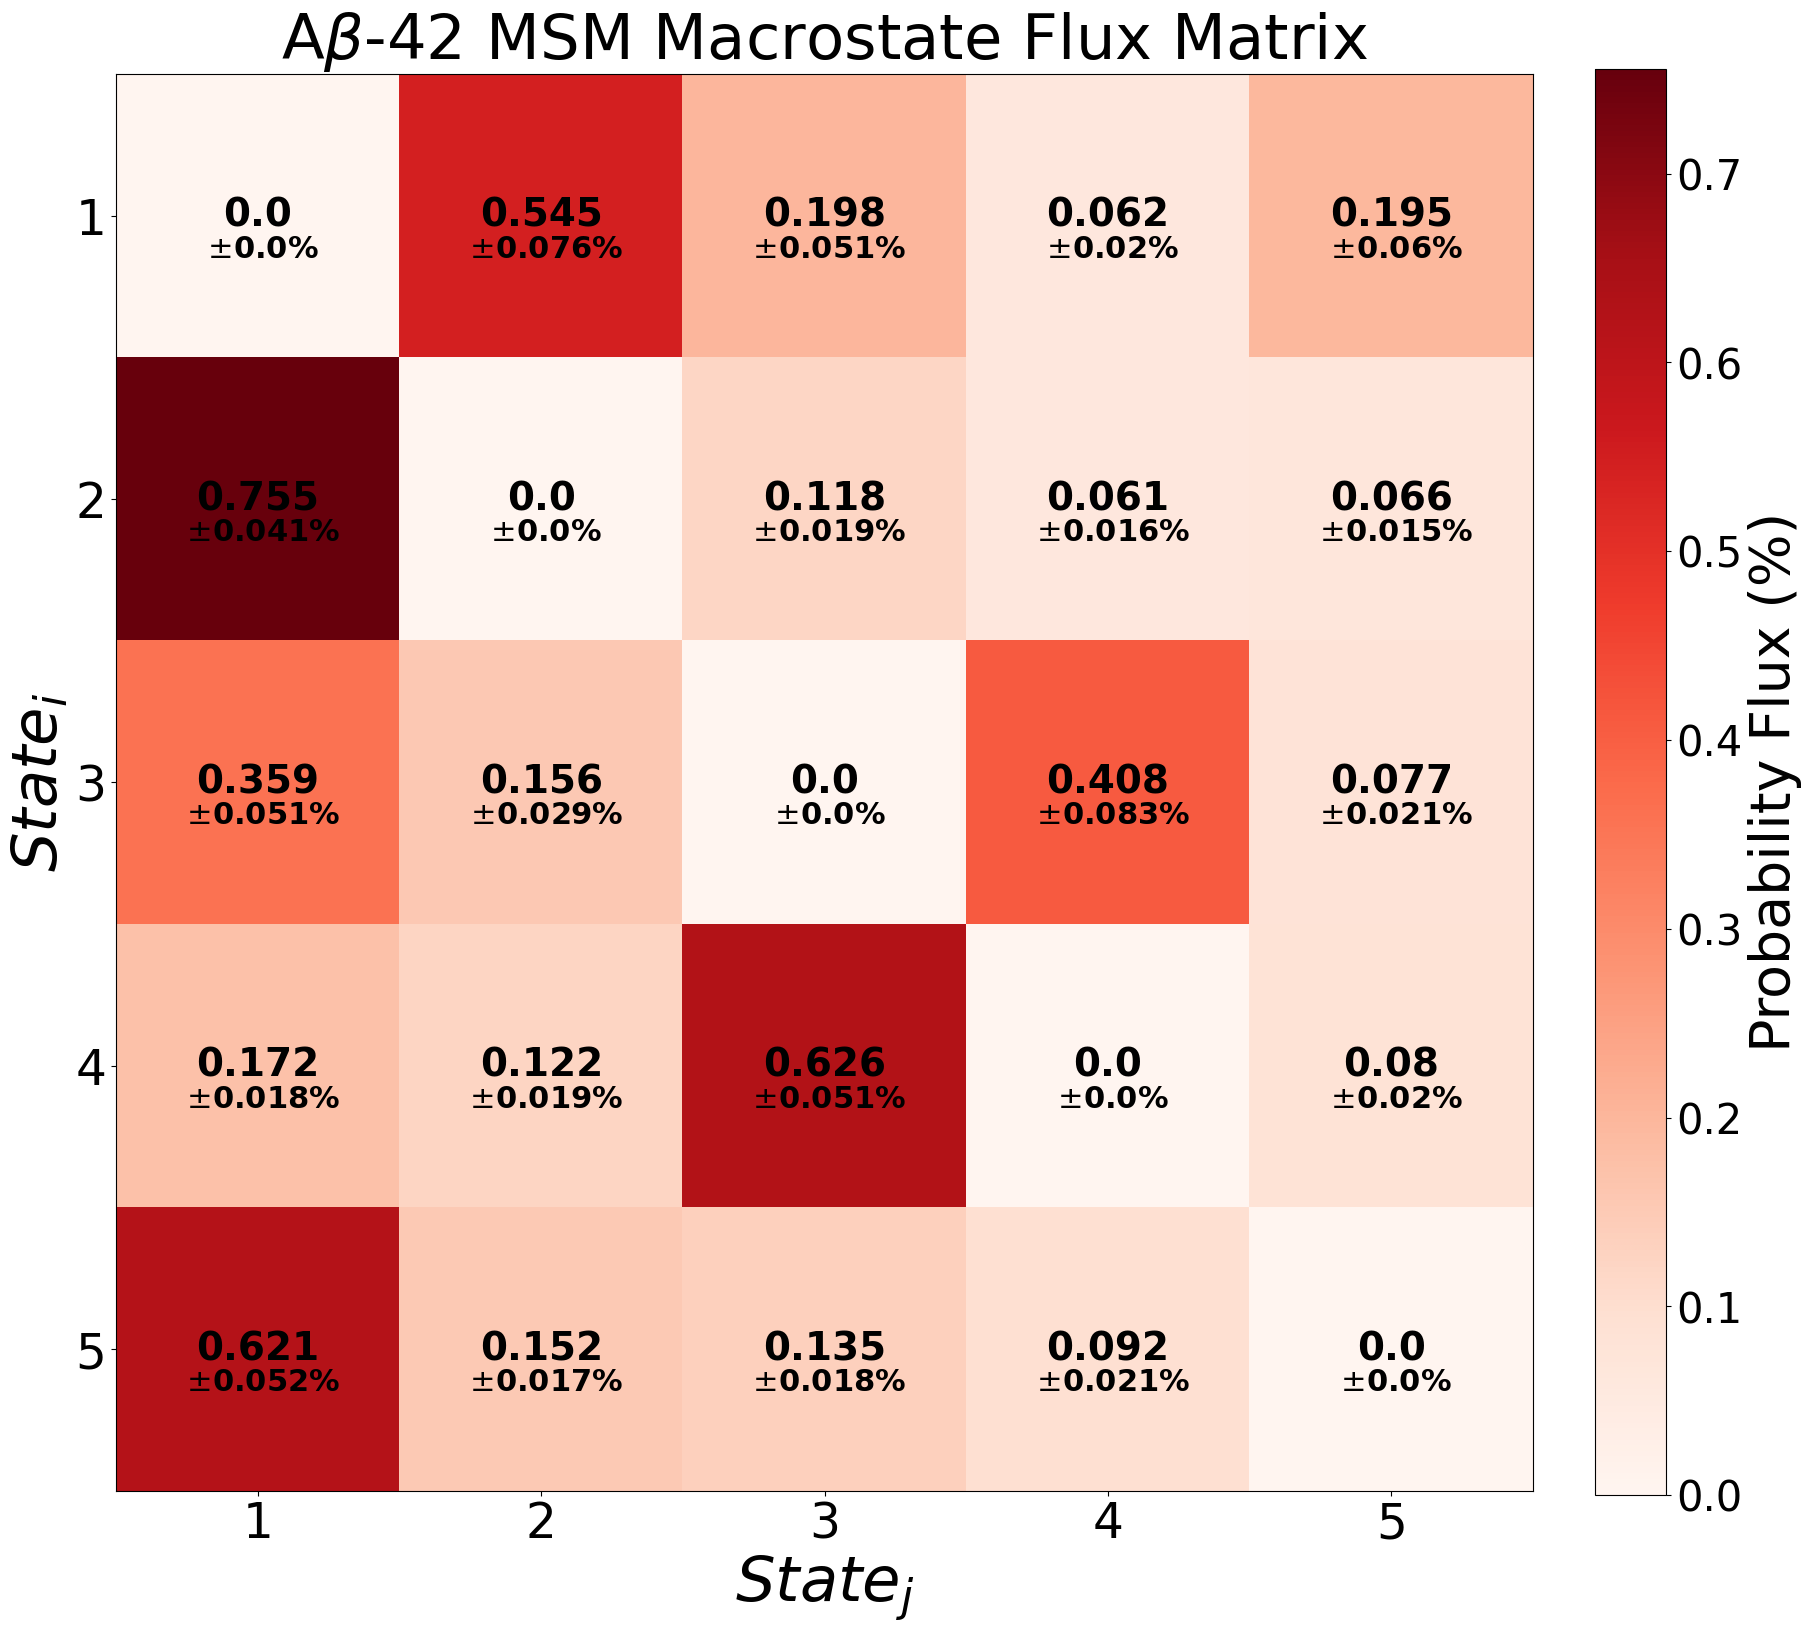

In [11]:
def flux_matrix(sample, metastable_sets):
    nsets = len(metastable_sets)
    matrix = np.zeros((nsets, nsets))
    for i in range(nsets):
        for j in range(nsets):
            if i != j:
                matrix[i, j] = sample.reactive_flux(metastable_sets[i], metastable_sets[j]).total_flux
    return matrix

flux = reindex_matrix(np.stack([flux_matrix(i, sets) for i in bmsm.samples]), idx)
flux /= flux.sum(2, keepdims=True)
flux_mu = flux.mean(0)
flux_err = np.diff(np.percentile(flux, [2.5, 97.5], axis=0), axis=0).squeeze() / 2 


annotated_matrix_plot(matrix = flux_mu,
               error_matrix = flux_err,
               title = r"A$\beta$-42 MSM Macrostate Flux Matrix",
               unit = "%",
               cbar_label = r"Probability Flux (%)",
               val_text_size = 28,
               err_text_size = 22,
               textcolor = "black",
                      alpha=1,
               cmap = "Reds",
               tick_labels = np.arange(1, n_states+1),
               decimals=3,
               #clims=(0, ),
              )
plt.savefig("flux.png", dpi=1000, bbox_inches='tight')

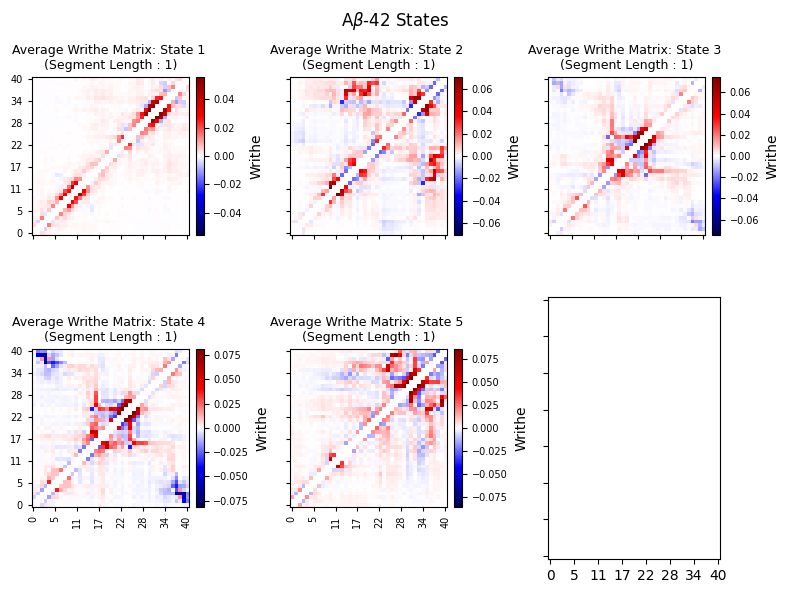

In [117]:
writhe = Writhe.load(lsdir(writhe_paths[-3])[0])
weights = (bmsm.gather_stats("stationary_distribution").mean /
           group_by(cluster['ab42']['writhe'][40][3], reduction=np.sum))[cluster['ab42']['writhe'][40][3]]
fig, axes = plt.subplots(2, 3, figsize=(8, 6), sharey=True, sharex=True)
for i, (frames, ax) in enumerate(zip(reindex_list(group_by(assignments[cluster['ab42']['writhe'][40][3]]),idx), axes.flat)):
    writhe.plot_writhe_matrix(index=frames, weights=weights[frames] * 100, dscr=f"State {i+1}", ax=ax)
fig.tight_layout()
fig.suptitle(f"{names[-3]} States")
plt.savefig("writhe.png", dpi=1000, bbox_inches='tight')
del writhe